# Tehtävä 5: koneoppimisen ja syväoppimisen toteutus 

- Tässä dokumentissa keskitytään edellisten tulosten optimointiin ja tarkempaan analyysiin.

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
df = pd.read_csv("../data/base.csv", low_memory=False)


pd.options.display.max_columns = None


import warnings
warnings.filterwarnings('ignore')

In [81]:
# Muutetaan päivänmäärä pelkästään vuodeksi, koska scalerit eivät toimi datatimen kanssa
df["installation_date"] = pd.to_datetime(df['installation_date']).dt.year

df.shape

(602955, 30)

In [82]:
# Siivotaan datasta pois rivit missä hinta/DC suhde on alle 1000 tai yli 10000
df = df[(df["total_installed_price"] / df["system_size_DC"] >= 1000) & (df["total_installed_price"] / df["system_size_DC"] <= 10000)]

df.shape

(583793, 30)

### Luetaan aikaisemmin käsitelty dataframe ja muodostetaan siitä erilaiset versiot

In [83]:
# Otetaan mukaan residential-järjestelmät, missä ei ole akkua
res = df[(df['residential'] == 1) & (df['battery'] == 0)]
# Otetaan mukaan residential-järjestelmät, missä on akku
res_bat = df[(df['residential'] == 1) & (df['battery'] == 1)]

# Otetaan mukaan non_residential-järjestelmät, missä ei ole akkua
non_res = df[(df['residential'] == 0) & (df['battery'] == 0)]
# Otetaan mukaan non_residential-järjestelmät, missä on akku
non_res_bat = df[(df['residential'] == 0) & (df['battery'] == 1)]


res = res.drop(columns=['battery', 'battery_rated_capacity_kW', 'residential'])
res_bat = res_bat.drop(columns=['battery', 'residential'])
non_res = non_res.drop(columns=['battery', 'battery_rated_capacity_kW', 'residential'])
non_res_bat = non_res_bat.drop(columns=['battery', 'residential'])

### Tehtävään valitut algoritmit

-Regressiomallit kuvaavat yhteyttä syötemuuttujien ja valitun tarkasteltavan muuttujan välillä. Regressiomenetelmät kuten lineaariregressio  tuottavat vastaukseksi lukuarvon, jonka ei tarvitse olla kokonaisluku. Tästä syystä se sopii hyvin tässä projektissa esimerkiksi hinnan ennustamiseen. Kaikki tarkasteluun otetut algoritmit ovat regressiomalleja. Tavoitteena on ajaa testit valituille malleille ja löytää niistä lähtökohtaisesti 3 parasta mallia, ja tämän jälkeen hienosäätää valitut mallit mahdollisimman tehokkaiksi.

In [84]:
# Ladataan tarvittavia kirjastoja
from math import sqrt
from pandas import MultiIndex, Int16Dtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler, PowerTransformer
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV

In [85]:
random_state = 42

# Tarkastelussa olevat algoritmit ja niille määritellyt default parametrit
models = {"RandomForest": RandomForestRegressor(random_state=random_state),
            "XGBoost": XGBRegressor(seed = random_state, tree_method="gpu_hist"),
            "CatBoost": CatBoostRegressor(random_seed = random_state, loss_function='RMSE', eval_metric ="MAE", verbose=False)
            }

In [86]:
# Alustetaan tarvittavia listoja
result_columns_list = ["DataFrame","Model","Scaler","RMSE train","RMSE test","R2 train","R2 test","MAE train","MAE test"]
scalers_list = ["None", StandardScaler(), RobustScaler(), MinMaxScaler()]

## Algoritmien vertailu

Rakennetaan funktio, jolle voi antaa parametrina eri datasettejä ja eri normalisointi funktiota. Funktio palauttaa dataframen missä on jokaiselle algoritmille laskettu arvot eri metriikoita käyttäen ja samalla piirretään kuvaaja, missä näkyy mielestämme mielenkiintoisin sarake eli 
ennustuksen Mean absolute error.

### Algoritmien paremmuuden määrittämiseen käytettiin seuraavia metriikoita: 

- RMSE = Root Mean Square Error. Keskineliövirheen neliöjuuri antaa normalisoidun etäisyyden ennustettujen arvojen vektorin ja pohjatotuutena olevan vektorin välillä. 
- R2 = R squared. R2-luku kertoo kuinka hyvin malli sovittuu regressiomalleissa opetusaineistoon. R2-luku kertoo kuinka suuren osuuden mallin muuttujat voivat selittää pohjatotuudesta.
- MAE = Mean absolute error.  Keskimääräinen absoluuttinen virhe antaa numeerisen arvon, joka kertoo kuinka paljon algoritmin tekemä arvio keskimäärin erosi pohjatotuudesta. 

In [87]:
def evaluate_models(df_name,df,scaler,models,result_columns=result_columns_list):    


    # Jaetaan data treeni ja testi settiin 

    y = df["total_installed_price"]
    X = df.drop(columns="total_installed_price")

    features = X.columns

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state) 

    tulos = pd.DataFrame(columns=result_columns)
    
    # Skaalataan data funktiokutsussa ilmoitetulla skaalaajalla

    if scaler != "None":

        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=features)        


    # Sovitetaan data mallille ja määritellään RMSE, R2 ja MAE testi- ja treeni-seteille ja tallennetaan ne dataframeen

    for name, model in models.items():
        

        model.fit(X_train,y_train)

        

        RMSE_test = sqrt(mean_squared_error(y_test, model.predict(X_test)))
        RMSE_train = sqrt(mean_squared_error(y_train, model.predict(X_train)))
        r2_test = r2_score(y_test, model.predict(X_test))
        r2_train = r2_score(y_train, model.predict(X_train))
        MAE_test = mean_absolute_error(y_test, model.predict(X_test))
        MAE_train = mean_absolute_error(y_train, model.predict(X_train))



        tulos.loc[len(tulos)] = [df_name,name,str(scaler),RMSE_train,RMSE_test,r2_train,r2_test,MAE_train,MAE_test]


        
    
    return tulos

In [88]:
# Funktio, millä voidaan siivota poikkeamat pois datasetistä käyttäen IQR-menetelmää

def exception_handling(df, battery = 0, last=0):

    print("Alkuperäisen DataFramen koko = ",df.shape)

    # Käytetään akullisille jäjestelmille pienempää feature-listaa, koska muuten dataframe menee tyhjäksi!

    if last == 1:
        features = ['system_size_DC', 'total_installed_price',        
                'inverter_total_capacity', 'module_quantity']
            
    elif battery == 1:

        features = ['system_size_DC', 'total_installed_price','inverter_loading_ratio', 'module_quantity','module_efficiency', 'inverter_total_capacity']
         
    else:
        features = ['system_size_DC', 'total_installed_price',        
                'inverter_loading_ratio', 'module_quantity','module_efficiency',
                'inverter_quantity', 'inverter_total_capacity']



    for col in features:

            alaraja, ylaraja = np.percentile(a=df[col], q=[25,75])
            iqr = ylaraja - alaraja
            #print((f"{col} Alaraja = {alaraja} Yläraja = {ylaraja} IQR = {iqr}"))

            # Tehdään uudet yla- ja alarajat missä mukana 1.5*IQR

            alaraja_iqr = alaraja - 1.5*iqr
            ylaraja_iqr = ylaraja + 1.5*iqr

            df = df[(df[col] > alaraja_iqr) & (df[col] < ylaraja_iqr)]
    
    print("Siivotun DataFramen koko = ",df.shape)        
    print("Keskihinta = ",df["total_installed_price"].mean())

    return df

In [89]:
# Funktio jolla voi piirtää kuvaajat dataseteistä

def draw_graph(df,df_name):

    df = df.sort_values("Model")

    plt.figure(figsize=(15,5))
    plt.title(f"Combination of {df_name} MAE test and R2 test values")
    plt.subplot(1,2,1)
    plt.title("Mean absolute error testset")
    sns.barplot(data=df,x ="Model", y="MAE test",hue="Scaler")
    plt.xticks(rotation=45,ha="right")
    plt.legend(loc='lower right')
    plt.subplot(1,2,2)
    plt.title("R2 score testset")
    sns.barplot(data=df,x ="Model", y="R2 test",hue="Scaler")
    plt.xticks(rotation=45,ha="right")
    plt.legend(loc='lower right')
    plt.show()


In [90]:
# Funktio, joka kutsuu aikaisemmat funktiot ja tulostaa tulokset

def print_results(df_name,df,models,scalers=scalers_list,result_columns=result_columns_list, battery=0):
    result_df = pd.DataFrame(columns=result_columns)

    # Siivotaan poikkeukset
    df_clean = exception_handling(df, battery)

    # Ajetaan eri skaalaajat evaluate_models funktion läpi
    for scaler in scalers:
        data = evaluate_models(df_name,df_clean,scaler,models,result_columns=result_columns_list)
        result_df = result_df.append(data).sort_values(["R2 test","MAE test", "Model"],ascending=False)
        
    # Piirretään kuvaaja
    draw_graph(result_df,df_name)


    return result_df

In [91]:
# Funktio, jolla voi optimoida algoritmien hyperparamettereita

def hyperparameters_optimizer(df, model, param_grid, exceptions=0):

        # Siivotaan poikkeamat
        if exceptions == 0:
                df = exception_handling(df)
        
        y = df["total_installed_price"]
        X = df.drop(columns="total_installed_price")

        # Alustetaan RandomizedSearchCV
        grid = RandomizedSearchCV(
                model,
                param_grid,
                n_iter=25, scoring='neg_mean_squared_error', verbose=1)

        # Sovitetaan data RandomizedSearchCV funktiolle
        grid.fit(X,y)

        # Tulostetaan parhaat parametrit
        return grid.best_params_
    

# ----------------TODO---------------------


- Paljon analyysiä jokaisen kuvaajan jälkeen
- Syy minkä takia ajetaan kolmella algoritmilla ja 4 skalerilla ja vielä optimoiduilla arvoilla erikseen
    - paras skaler tuntuu olevan joka ajolla eri, ---> laita heittely väli analyyseihin
    - optimoidut arvot antavat mielenkiintoisia tuloksia non-optimoituihin verrattuna, esim sekottaa algoritmit ja skaalaajat  ---> analysoi näitä
- Feature importances kuvaaja parhaalle res datasetin ja skaalaajan tulokselle
    - poistetaan turhimmat sarakkeet ja ajetaan vielä 
        - kaikki läpi? / kaikki läpi samaan kuvaajaan? / paras algortimi + skaalaaja samaan kuvaajaan?

- Neuroverkon parannusta ---> koittaa saada vähintään sama tulos mitä koneoppimisesta
    - kattoa feature importance kuvaajaa neuroverkosta, jos pystyy, jos ei nii käyttää koneoppimisesta saatuja tuloksia?


## Akulliset residential kohteet
- Tässä setissä hinnan keskiarvo = 34546.66435248511
- Dataframen koko = 4416

Alkuperäisen DataFramen koko =  (6005, 28)
Siivotun DataFramen koko =  (4307, 28)
Keskihinta =  34612.961820292476


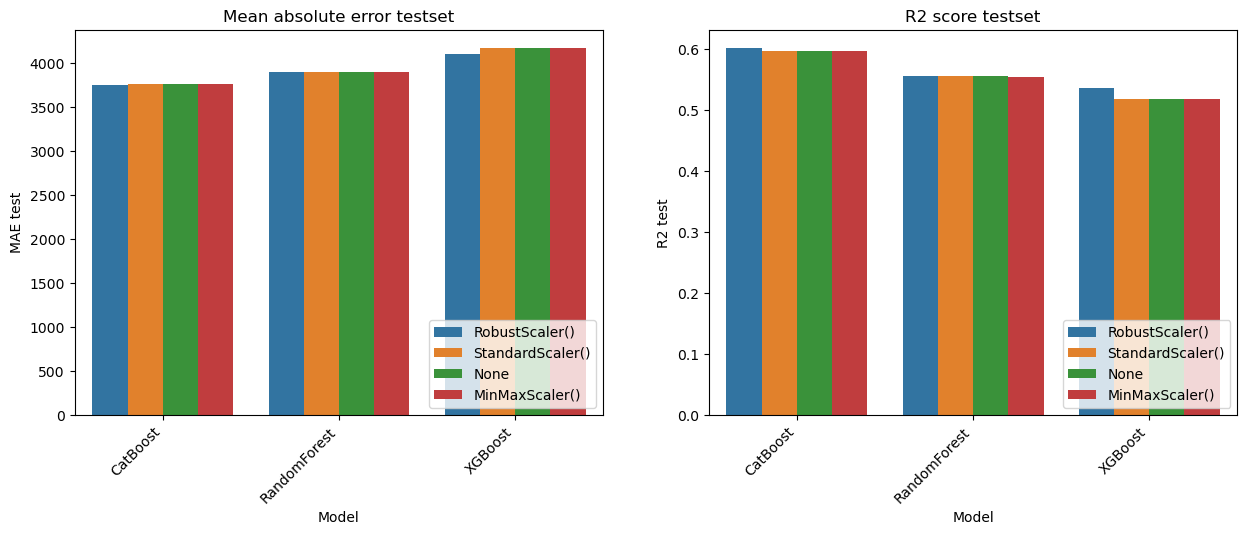

,DataFrame,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
2,Res_bat_default,CatBoost,RobustScaler(),3095.101892,5783.861503,0.887775,0.600668,2100.388272,3753.039173
2,Res_bat_default,CatBoost,StandardScaler(),3143.598467,5817.026020,0.884231,0.596075,2133.390207,3760.067539
2,Res_bat_default,CatBoost,None,3143.598467,5817.102788,0.884231,0.596065,2133.390207,3759.910377
2,Res_bat_default,CatBoost,MinMaxScaler(),3143.598467,5817.682408,0.884231,0.595984,2133.390207,3759.525802
0,Res_bat_default,RandomForest,RobustScaler(),2318.706288,6106.657030,0.937016,0.554851,1442.047709,3898.687254
0,Res_bat_default,RandomForest,None,2316.048973,6108.028079,0.937160,0.554651,1439.581355,3895.352277
0,Res_bat_default,RandomForest,StandardScaler(),2316.384083,6110.199336,0.937142,0.554335,1439.427301,3894.171068
0,Res_bat_default,RandomForest,MinMaxScaler(),2317.449234,6112.409262,0.937084,0.554012,1440.282303,3897.338280
1,Res_bat_default,XGBoost,RobustScaler(),1624.836787,6235.847965,0.969072,0.535817,1076.577605,4102.302747
1,Res_bat_default,XGBoost,None,1662.921660,6354.305983,0.967605,0.518014,1111.450624,4167.990355


In [92]:
name = "Res_bat_default"

res_bat_result = print_results(name, res_bat, models,battery=1)
res_bat_result

In [93]:
res_bat_result.describe().T

,count,mean,std,min,25%,50%,75%,max
RMSE train,12.0,2367.340637,631.547681,1624.836787,1662.921660,2316.916658,3107.226036,3143.598467
RMSE test,12.0,6080.977695,223.249911,5783.861503,5817.537503,6109.113707,6265.462469,6354.305983
R2 train,12.0,0.930063,0.035724,0.884231,0.886889,0.937113,0.967605,0.969072
R2 test,12.0,0.558042,0.032335,0.518014,0.531366,0.554493,0.596004,0.600668
MAE train,12.0,1556.068920,444.433589,1076.577605,1111.450624,1439.931829,2108.638756,2133.390207
MAE test,12.0,3935.363798,171.086576,3753.039173,3760.028249,3896.345278,4118.724649,4167.990355


# UUDET ANALYYSIT

### Mietteitä ja huomioita akullisista residential systeemeistä

- Poikkeamien poistaminen laski MAE:n arvoa noin 2000:lla ja R2 scoressa oli myös pieniä parannuksia
- MAE heitti parhaimmillaan 3800 pohjatotuudesta, mikä keskiarvoon nähden ei ole huono, mutta ei myöskään loistava
- Kaikkien algoitmien R2 train oli huomattavasti parempi, mitä vastaava R2 test. Tästä voisi päätellä, että mallit ovat reippaasti ylioppineita

# Tähän ehkä vähän tarinaa CatBoostista?

### Käytössä olevien algoritmien määrän vähentäminen

Esikarsinnan tuloksena valikoitui 3 algoritmia: RandomForest, CatBoost, ja XGBoost Regressor. Kaikki näistä ovat päätöspuihin perustuvia algoritmeja. 
 
Päätöspuiden avulla pyritään kuvaamaan dataa puurakenteen avulla. Oksat kuvaavat datapisteestä tehtyjä havaintoja ja solmut johtopäätöksiä datapisteen siitä muuttujasta, jota päätöspuun avulla halutaan ennakoida. Gradienttitehostetut päätöspuut yhdistävät useita päätöspuita ennusteen tekemiseksi. Päätöspuut ovat tehokkaita käytettynä koneoppimisessa ja niitä voidaan käyttää monimutkaisiin aineistoihin ja ne sopivat myös regressiotehtäviin ,joten ne soveltuvat hyvin tähän projektiin.
 
Oikein säädettynä gradienttitehostetuiden puiden pitäisi suoriutua paremmin kuin satunnaismetsä(random forest tree). Tehostetut puut luovat yhden puun kerrallaan ja jokainen uusi puu yrittää parantaa edellisen puun suoritusta. Satunnaismetsä kouluttaa jokaisen puun itsenäisenä yksikkönä satunnaisella näytteellä datasta. Satunnaisuuden vuoksi mallissa ei tapahdu niin helposti ylioppimista.



### Hyperparametrien optimointi
Tehdään hyperparametrien optimointi käyttäen sklearnin RandomizedSearchCV algortimia.

# --------------------------ÄLÄ AJA SEURAAVAA KOLMEA-------------------------------------

- Pitääskö nämä poistaa.... tai ehkä muokata funktioksi tämäkin

In [94]:

model = RandomForestRegressor(random_state=random_state)

# Määritellään kokeiltavat parametrit

param_grid = [
                {'bootstrap': [True, False],
                'max_depth': [3,6,7,9,10, 20, None],
                'max_features': ['auto', 'sqrt', None],
                'min_samples_leaf': [1, 2, 4],
                'min_samples_split': [2, 4, 6],
                'n_estimators': [800, 1000, 1200, 1400, 1600, 1800, 2000]}
                ]

# Randomforest on käyteyistä algoritmeista kaikista hitain, joten optimoidaan se randomisti valitulla 50000 rivin otannalla
df_sample = exception_handling(res).sample(50000)
print("Sample df size = ", df_sample.shape)

#hyperparameters_optimizer(df_sample, model, param_grid, exceptions=1)

Alkuperäisen DataFramen koko =  (566899, 27)
Siivotun DataFramen koko =  (509629, 27)
Keskihinta =  24669.68603242413
Sample df size =  (50000, 27)


In [95]:
model = CatBoostRegressor(random_seed = random_state, loss_function='RMSE', eval_metric ="MAE", verbose=False)

param_grid = [
                {'depth':[3,1,2,6,4,5,7,8,9,10],
                'iterations':[250,100,500,1000],
                'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
                'l2_leaf_reg':[3,1,5,10,100],
                'border_count':[32,5,10,20,50,100,200],
                'subsample':[0.5, 0.7, 1.0]}]

#hyperparameters_optimizer(res, model, param_grid)

In [96]:
model = XGBRegressor(seed=random_state, tree_method="gpu_hist")

param_grid = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

#hyperparameters_optimizer(res, model, param_grid)

#### optimointien tulokset:

- RandomForest: dataset = res.sample(50000), runtime= n. 6h, runtime koko dataset yli 13h

    - {'n_estimators': 1000,
    - 'min_samples_split': 4,
    - 'min_samples_leaf': 2,
    - 'max_features': 'auto',
    - 'max_depth': 10,
    - 'bootstrap': True}

- CatBoostRegressor: dataset = res, runtime = n. 17min
    - {'subsample': 0.5,
    - 'learning_rate': 0.3,
    - 'l2_leaf_reg': 10,
    - 'iterations': 1000,
    - 'depth': 10,
    - 'border_count': 200}

- XGBRegressor: dataset = res, runtime = n. 3h
    - {'subsample': 0.8999999999999999,
    - 'n_estimators': 2000,
    - 'max_depth': 6,
    - 'learning_rate': 0.1,
    - 'colsample_bytree': 0.7,
    - 'colsample_bylevel': 0.8999999999999999}


Otetaan RandomizedSearchCV algoritmin ehdotukset käyttöön ja koitetaan ajaa vielä yksi testi samalla datasetillä

In [97]:

models_tuned = {"RandomForest": RandomForestRegressor(n_estimators=1000, max_features='auto',max_depth=10, min_samples_leaf=2, min_samples_split=4, bootstrap=True, random_state=random_state),
            "CatBoost":CatBoostRegressor(random_seed = random_state, loss_function='RMSE', eval_metric ="MAE", verbose=False,subsample=0.5,learning_rate=0.3,l2_leaf_reg=10,iterations=1000,depth=10,border_count=200),
            "XGBoost Regressor": XGBRegressor(subsample=0.9,n_estimators=2000, max_depth=6,learning_rate=0.1,colsample_bytree= 0.7,colsample_bylevel=0.9,seed = random_state, tree_method="gpu_hist")           
            }

Ajetaan datasetti res_bat uudestaan optimoiduilla arvoilla

Alkuperäisen DataFramen koko =  (6005, 28)
Siivotun DataFramen koko =  (4307, 28)
Keskihinta =  34612.961820292476


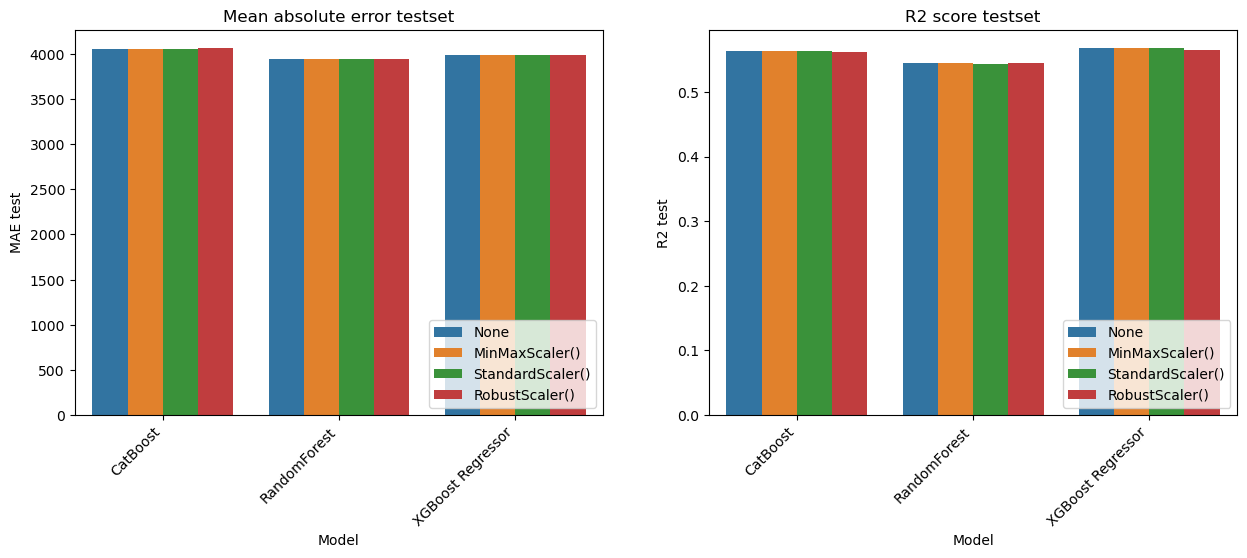

,DataFrame,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
2,Res_bat_tuned,XGBoost Regressor,StandardScaler(),205.792415,6017.688693,0.999504,0.567727,28.095004,3985.410726
2,Res_bat_tuned,XGBoost Regressor,None,205.792415,6018.930219,0.999504,0.567549,28.095004,3985.929460
2,Res_bat_tuned,XGBoost Regressor,MinMaxScaler(),205.792415,6018.930219,0.999504,0.567549,28.095004,3985.929460
2,Res_bat_tuned,XGBoost Regressor,RobustScaler(),205.317361,6031.880412,0.999506,0.565686,26.113112,3989.800113
1,Res_bat_tuned,CatBoost,None,266.046275,6042.920867,0.999171,0.564095,116.924119,4061.574198
1,Res_bat_tuned,CatBoost,MinMaxScaler(),266.046275,6042.951651,0.999171,0.564090,116.924119,4061.559035
1,Res_bat_tuned,CatBoost,StandardScaler(),266.046275,6043.090920,0.999171,0.564070,116.924119,4061.850579
1,Res_bat_tuned,CatBoost,RobustScaler(),263.086507,6060.058813,0.999189,0.561619,112.998535,4065.668934
0,Res_bat_tuned,RandomForest,None,3994.978442,6179.183816,0.813032,0.544215,2612.716607,3947.385649
0,Res_bat_tuned,RandomForest,RobustScaler(),3995.137625,6179.915424,0.813017,0.544107,2612.770187,3947.819510


In [98]:
name = "Res_bat_tuned"
res_bat_result_optimal = print_results(name,res_bat, models_tuned, battery=1)
res_bat_result_optimal

In [99]:

res_bat_result_optimal.describe().T

,count,mean,std,min,25%,50%,75%,max
RMSE train,12.0,1488.685227,1851.266839,205.317361,205.792415,266.046275,3994.997635,3995.137625
RMSE test,12.0,6083.067817,72.692447,6017.688693,6028.642863,6043.021286,6179.366718,6181.166275
R2 train,12.0,0.937234,0.091736,0.813017,0.813030,0.999171,0.999504,0.999506
R2 test,12.0,0.558226,0.010594,0.543922,0.544188,0.564080,0.566152,0.567727
MAE train,12.0,918.748100,1251.635418,26.113112,28.095004,116.924119,2612.593113,2612.770187
MAE test,12.0,3998.986158,49.938943,3947.184570,3947.795047,3985.929460,4061.562826,4065.668934


# UUDET ANALYYSIT


- Käyttämällä RandomizedSearchCV arvoja MAE testin arvot laskivat vielä noin 200-300.
- R2 train arvo tippu XGBoost regressorilla, mutta nousi Gradient Tree:llä. Randomforestilla pysyi melko samana
- R2 test arvot nousivat jokaisella algoritmillä, mikä on hyvä asia. Tosin ne vieläkin ovat 60% kieppeillä

## Non_residential kohteita sisältävä datasetti

-Seuraavaksi käsittelyssä non_res datasetti, mikä pitää sisällään kaikki non_residential kohteet.


Alkuperäisen DataFramen koko =  (10743, 27)
Siivotun DataFramen koko =  (5894, 27)
Keskihinta =  111325.42076348828


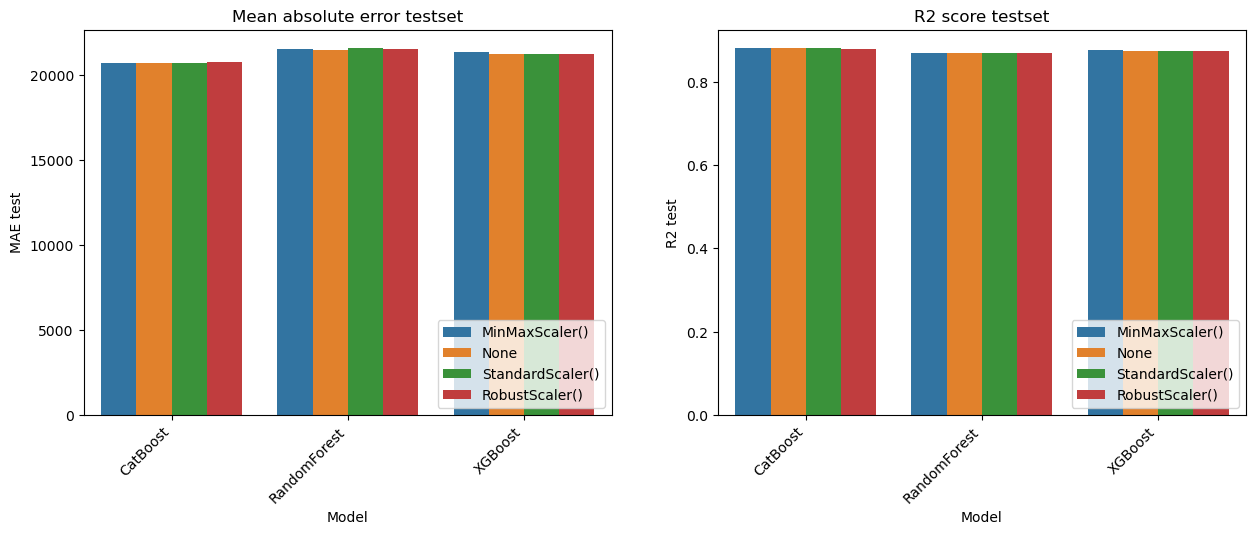

,DataFrame,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
2,Non_res_default,CatBoost,MinMaxScaler(),16774.865355,38808.797791,0.976201,0.880382,11026.016586,20672.576867
2,Non_res_default,CatBoost,None,16774.865355,38809.716127,0.976201,0.880377,11026.016586,20673.354720
2,Non_res_default,CatBoost,StandardScaler(),16774.865355,38811.175178,0.976201,0.880368,11026.016586,20675.265140
2,Non_res_default,CatBoost,RobustScaler(),17009.547700,38940.678099,0.975530,0.879568,11133.753716,20753.294748
1,Non_res_default,XGBoost,MinMaxScaler(),8304.722852,39609.150311,0.994167,0.875398,5490.341716,21333.834086
1,Non_res_default,XGBoost,None,8528.221384,39743.205409,0.993849,0.874553,5595.844748,21195.165888
1,Non_res_default,XGBoost,StandardScaler(),8528.221384,39743.205409,0.993849,0.874553,5595.844748,21195.165888
1,Non_res_default,XGBoost,RobustScaler(),8528.221384,39743.205409,0.993849,0.874553,5595.844748,21195.165888
0,Non_res_default,RandomForest,None,14433.883701,40493.597361,0.982380,0.869771,8074.295101,21469.557653
0,Non_res_default,RandomForest,RobustScaler(),14403.240398,40535.236711,0.982454,0.869503,8056.062672,21511.826094


In [100]:
name = "Non_res_default"

non_res_result = print_results(name,non_res, models)
non_res_result

In [101]:
non_res_result.describe().T

,count,mean,std,min,25%,50%,75%,max
RMSE train,12.0,13240.028946,3670.154953,8304.722852,8528.221384,14409.846239,16774.865355,17009.547700
RMSE test,12.0,39702.257961,732.066446,38808.797791,38908.302368,39743.205409,40504.007198,40596.716167
R2 train,12.0,0.984130,0.007736,0.975530,0.976201,0.982438,0.993849,0.994167
R2 test,12.0,0.874772,0.004616,0.869107,0.869704,0.874553,0.879768,0.880382
MAE train,12.0,8229.298087,2341.628018,5490.341716,5595.844748,8065.769918,11026.016586,11133.753716
MAE test,12.0,21144.669342,356.823009,20672.576867,20733.787346,21195.165888,21480.124763,21548.314205


# analyysit nonres default

# VAATII LISÄÄ
#### Ajetaan non_res datasetti läpi optimoiduilla hyperparametereilla

Alkuperäisen DataFramen koko =  (10743, 27)
Siivotun DataFramen koko =  (5894, 27)
Keskihinta =  111325.42076348828


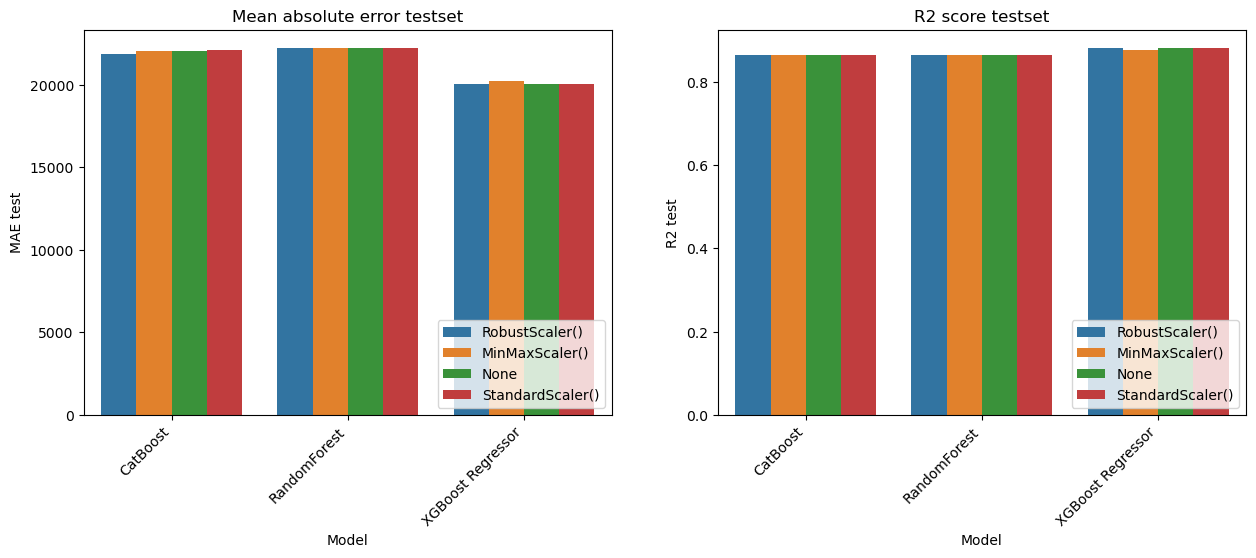

,DataFrame,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
2,Non_res_tuned,XGBoost Regressor,None,1205.231210,38718.205685,0.999877,0.880940,244.760071,20039.914927
2,Non_res_tuned,XGBoost Regressor,StandardScaler(),1205.231210,38718.205685,0.999877,0.880940,244.760071,20039.914927
2,Non_res_tuned,XGBoost Regressor,RobustScaler(),1206.400171,38834.115669,0.999877,0.880226,247.091848,20078.572253
2,Non_res_tuned,XGBoost Regressor,MinMaxScaler(),1208.626615,39446.783634,0.999876,0.876417,252.364021,20247.507361
1,Non_res_tuned,CatBoost,RobustScaler(),1312.628319,41246.045135,0.999854,0.864886,445.067562,21860.196524
0,Non_res_tuned,RandomForest,None,22116.647599,41262.841000,0.958630,0.864776,13339.765137,22213.437706
0,Non_res_tuned,RandomForest,MinMaxScaler(),22117.211968,41263.051822,0.958628,0.864775,13340.767894,22210.540113
0,Non_res_tuned,RandomForest,RobustScaler(),22114.703952,41282.135255,0.958637,0.864650,13337.371897,22210.385980
0,Non_res_tuned,RandomForest,StandardScaler(),22116.044065,41286.788585,0.958632,0.864619,13340.975547,22221.514345
1,Non_res_tuned,CatBoost,MinMaxScaler(),1319.446285,41447.672653,0.999853,0.863562,452.642699,22079.664685


In [102]:
name = "Non_res_tuned"
non_res_result_optimized = print_results(name,non_res, models_tuned)
non_res_result_optimized

In [103]:
non_res_result_optimized.describe().T

,count,mean,std,min,25%,50%,75%,max
RMSE train,12.0,8213.421997,10267.956530,1205.231210,1208.070004,1319.446285,22115.038980,22117.211968
RMSE test,12.0,40535.430720,1202.670205,38718.205685,39293.616643,41262.946411,41327.009602,41466.877031
R2 train,12.0,0.986121,0.020302,0.958628,0.958636,0.999853,0.999877,0.999877
R2 test,12.0,0.869396,0.007660,0.863436,0.864355,0.864775,0.877369,0.880940
MAE train,12.0,4679.237679,6396.779409,244.760071,251.045978,452.642699,13337.970207,13340.975547
MAE test,12.0,21448.287490,1000.881216,20039.914927,20205.273584,22080.071900,22210.424513,22221.514345


# KIRJOITA UUDET MIETTEET

### Mietteitä ja huomioita
- Poikkeamien pois ottaminen laski MAE:n arvoa noin 100000 ja samalla r2_test tulos nuosi noin 1 - 5 % algoritmista riippuen.
- Lopullinen MAE arvo oli noin 25000, joka keskiarvoon verrattuna on erittäin iso.
- Tässä setissä R2 train ja R2 test arvot olivat huomattavasti lähempänä toisiaan
- Myös R2 test arvot alkavat olemaan ylu 80%, joka alkaa tuntumaan jo ihan hyvältä arvolta


## Residential kohteita sisältävä dataset
- Tämä on tutkittavista dataseteistä suurin. Rivejä on vähän reilu 500000.

Alkuperäisen DataFramen koko =  (566899, 27)
Siivotun DataFramen koko =  (509629, 27)
Keskihinta =  24669.68603242413


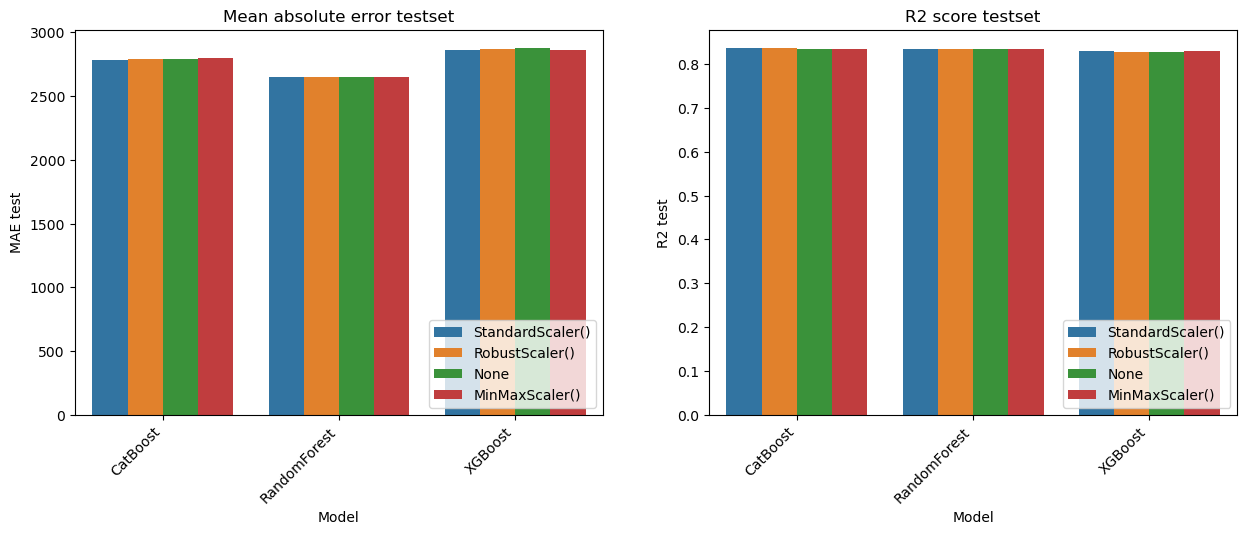

,DataFrame,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
2,Res_default,CatBoost,StandardScaler(),4301.155660,4355.574203,0.840475,0.836071,2756.037554,2783.028812
2,Res_default,CatBoost,RobustScaler(),4305.187504,4359.876088,0.840176,0.835747,2760.248444,2787.300552
2,Res_default,CatBoost,None,4311.904061,4365.868727,0.839677,0.835295,2764.813334,2790.862621
2,Res_default,CatBoost,MinMaxScaler(),4315.902761,4368.452784,0.839380,0.835100,2771.177333,2796.332921
0,Res_default,RandomForest,MinMaxScaler(),1664.588890,4368.481653,0.976107,0.835098,1001.922980,2647.384879
0,Res_default,RandomForest,StandardScaler(),1664.230490,4369.788626,0.976117,0.834999,1001.676980,2648.028265
0,Res_default,RandomForest,RobustScaler(),1664.171462,4370.363240,0.976119,0.834956,1001.668073,2648.122796
0,Res_default,RandomForest,None,1664.471530,4370.591139,0.976110,0.834939,1001.784938,2648.681560
1,Res_default,XGBoost,StandardScaler(),4320.277481,4446.834673,0.839054,0.829130,2798.918949,2863.716431
1,Res_default,XGBoost,MinMaxScaler(),4320.277481,4446.834673,0.839054,0.829130,2798.918949,2863.716431


In [104]:
name = "Res_default"

res_result = print_results(name,res, models)
res_result

In [105]:
res_result.describe().T

,count,mean,std,min,25%,50%,75%,max
RMSE train,12.0,3433.676648,1306.763964,1664.171462,1664.559550,4308.545782,4320.277481,4340.314720
RMSE test,12.0,4395.551521,43.958567,4355.574203,4367.806769,4370.075933,4446.834673,4465.925850
R2 train,12.0,0.884836,0.067417,0.837557,0.839054,0.839927,0.976108,0.976119
R2 test,12.0,0.833033,0.003351,0.827659,0.829130,0.834978,0.835149,0.836071
MAE train,12.0,2189.636123,877.490224,1001.668073,1001.888469,2762.530889,2798.918949,2813.258844
MAE test,12.0,2768.445373,95.095916,2647.384879,2648.541869,2789.081586,2863.716431,2874.821158


# analyysit res default

Alkuperäisen DataFramen koko =  (566899, 27)
Siivotun DataFramen koko =  (509629, 27)
Keskihinta =  24669.68603242413


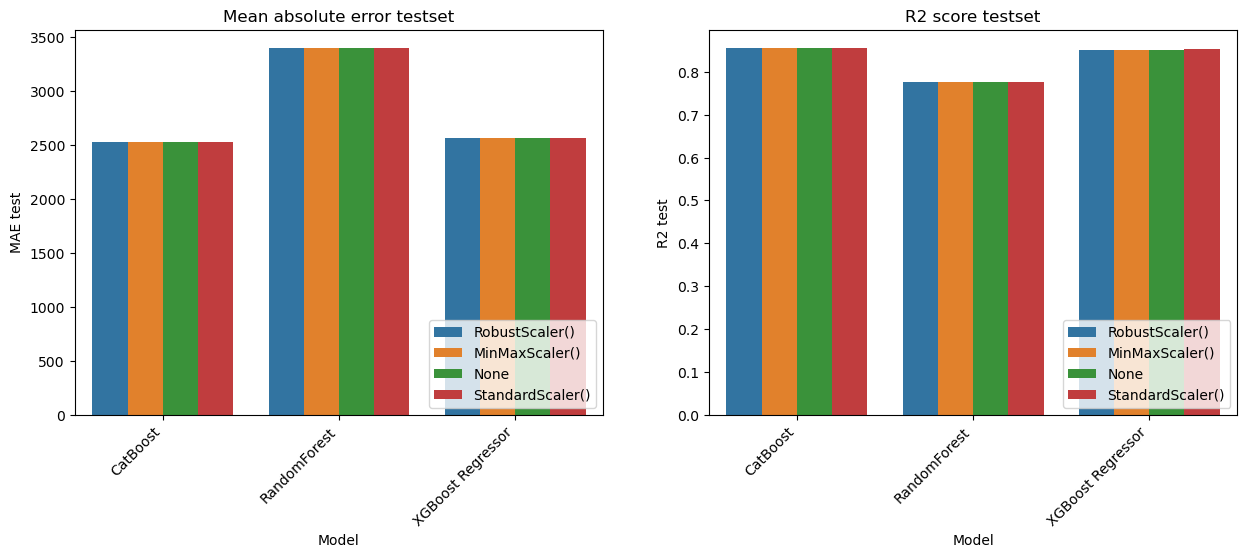

,DataFrame,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
1,Res_tuned,CatBoost,RobustScaler(),3307.404462,4095.947372,0.905674,0.855032,2081.172685,2525.938087
1,Res_tuned,CatBoost,MinMaxScaler(),3302.003577,4098.465615,0.905982,0.854853,2078.478789,2527.814880
1,Res_tuned,CatBoost,None,3296.254859,4098.734568,0.906309,0.854834,2075.577564,2531.339007
1,Res_tuned,CatBoost,StandardScaler(),3302.684320,4102.541812,0.905943,0.854564,2078.994990,2533.930591
2,Res_tuned,XGBoost Regressor,StandardScaler(),3493.885065,4138.531846,0.894737,0.852001,2209.120638,2565.919212
2,Res_tuned,XGBoost Regressor,MinMaxScaler(),3496.185487,4139.323086,0.894599,0.851945,2209.997414,2565.398067
2,Res_tuned,XGBoost Regressor,None,3495.433145,4141.240958,0.894644,0.851808,2208.803840,2566.803887
2,Res_tuned,XGBoost Regressor,RobustScaler(),3495.436588,4142.286727,0.894644,0.851733,2210.780879,2568.467706
0,Res_tuned,RandomForest,RobustScaler(),5051.875152,5096.618322,0.779929,0.775545,3375.804442,3400.179540
0,Res_tuned,RandomForest,MinMaxScaler(),5051.912770,5096.646756,0.779926,0.775543,3375.834367,3400.232097


In [107]:
name = "Res_tuned"
res_result_optimized = print_results(name, res, models_tuned)
res_result_optimized

In [108]:
res_result_optimized.describe().T

,count,mean,std,min,25%,50%,75%,max
RMSE train,12.0,3949.736586,818.152178,3296.254859,3306.224427,3495.434866,5051.876017,5051.912770
RMSE test,12.0,4445.305590,481.375921,4095.947372,4101.590001,4140.282022,5096.625430,5096.666680
R2 train,12.0,0.860187,0.059472,0.779926,0.779929,0.894644,0.905741,0.906309
R2 test,12.0,0.827412,0.038329,0.775541,0.775545,0.851876,0.854632,0.855032
MAE train,12.0,2554.682056,609.019606,2075.577564,2080.628261,2209.559026,3375.805682,3375.834367
MAE test,12.0,2832.206896,419.803438,2525.938087,2533.282695,2566.361549,3400.188269,3400.245213


# UUDET MIETTEET!!!

- Viimmeisenä ajettiin res_clean dataset mikä sisälti residential kohteet ilman akkuja. Tämä datasetti oli huomattavasti suurempi mitä kaksi edellistä. Kokoa tällä oli noin 500 000 riviä.
- Tässä datasetissä kirkkaasti parhaiten pärjäsi RandomForest.
- R2 arvot jättivät toivomisen varaa ollen parhaillaan 81% ja muuten 75-76%.
- Setin hinnan keskiarvoon 24299.369687 nähden, randomForestin MAE 2813 tuntuu melko hyvältä, tosin pienempi se voisi olla.


### Dataframen sarakkeiden optimointi

- Koska melkein kaikissa testeissä algoritmit olivat ylioppineita, koitetaan tätä ongelmaa parantaa vähentämällä ns."turhia" sarakkeita pois

- otetaan defaul randomforest takaisin käyttöön, koska sillä saatiin parempi tulos

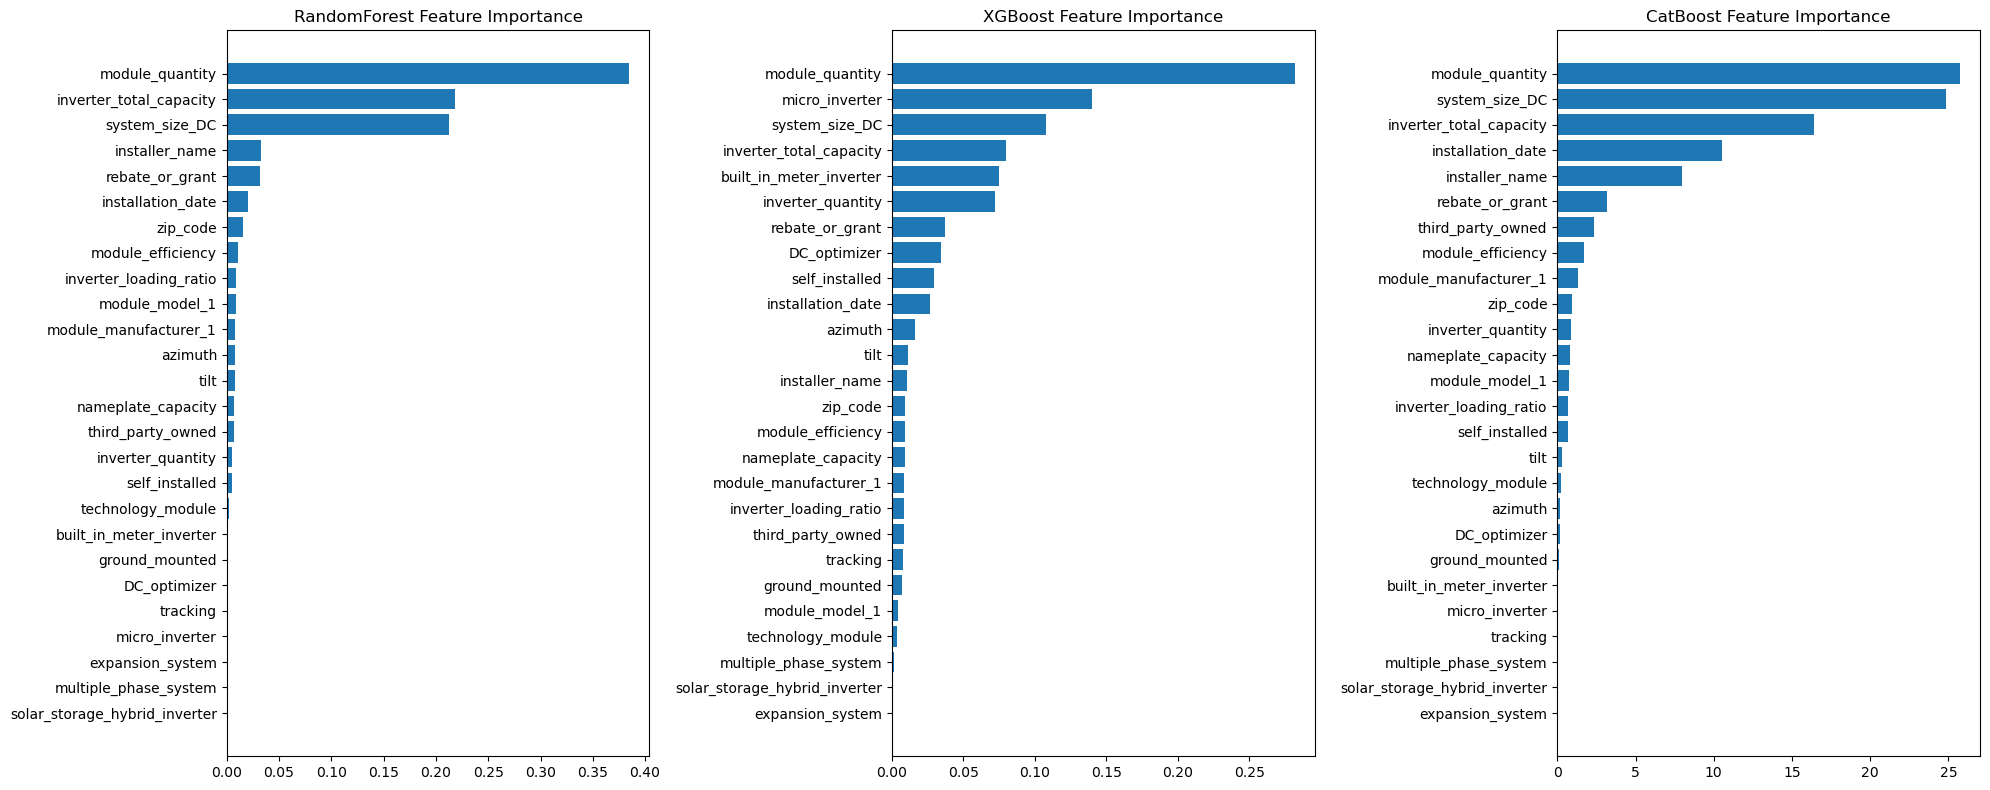

In [110]:
models_tuned = {"RandomForest": RandomForestRegressor(random_state=random_state),
            "CatBoost":CatBoostRegressor(random_seed = random_state, loss_function='RMSE', eval_metric ="MAE", verbose=False,subsample=0.5,learning_rate=0.3,l2_leaf_reg=10,iterations=1000,depth=10,border_count=200),
            "XGBoost Regressor": XGBRegressor(subsample=0.9,n_estimators=2000, max_depth=6,learning_rate=0.1,colsample_bytree= 0.7,colsample_bylevel=0.9,seed = random_state, tree_method="gpu_hist")           
            }
best_scaler = RobustScaler()
features_df = res

y = features_df["total_installed_price"]
X = features_df.drop(columns="total_installed_price")

features = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)
    
# Skaalataan data StandardSclaerilla ilmoitetulla skaalaajalla

X_train = pd.DataFrame(best_scaler.fit_transform(X_train), columns=features)
X_test = pd.DataFrame(best_scaler.transform(X_test), columns=features)      
count = 0

plt.figure(figsize=(20,8))
for name, model in models.items():        

        model.fit(X_train,y_train) 
    
        # Käsitellään dataframen feature_importances ja piirretään niistä kuvaajat
        count +=1
        importances = model.feature_importances_
        sorted_importances = np.argsort(importances)                    
        plt.subplot(1,3,count)
        plt.barh(X.columns[sorted_importances], importances[sorted_importances])
        plt.title(f"{name} Feature Importance")
        
plt.tight_layout()
plt.show()



### Analyysiä featureista
- Module_quantity osoittautui tärkeimmäksi sarakkeeksi kaikilla algortimeilla, joka sinäsä on loogista, koska moduulit ovat ne asiat mitkä maksavat ja niitä on eri kokoisia, joten se merkitsee enemmän, kuin system_size_DC. Myös system_size_DC ja inverter_total_capasity ovat loogisia olemaan kolmen parhaan joukossa. XGBoostille micro_inverterin oleminen toiseksi tärkeimpän on yllättävä poikkeus, koska muille algoritmeille, sillä ei näytä olevan mitään merkitystä. Myös erikoista on se, että XGBoostille melkein jokaisella sarakkeella on vähintää pieni merkitys, verrattuna muihin algoritmeihin. 
- Koska CatBoost antoi parhaan ennustuksen, päätimme pudottaa CatBoostille vähiten merkitsevät sarakkeet pois. Rajaksi valikoitui "self_installed" ja kaikki sen alapuolella olevat tiputettiin pois.
- Tiputetaan valikoidut sarakkeet pois ja ajetaan parhaalla algoritmilla ja scalerilla vielä kaikki datasetit läpi.

Alkuperäisen DataFramen koko =  (6005, 16)
Siivotun DataFramen koko =  (4307, 16)
Keskihinta =  34612.961820292476
Alkuperäisen DataFramen koko =  (10743, 15)
Siivotun DataFramen koko =  (5894, 15)
Keskihinta =  111325.42076348828
Alkuperäisen DataFramen koko =  (566899, 15)
Siivotun DataFramen koko =  (509629, 15)
Keskihinta =  24669.68603242413


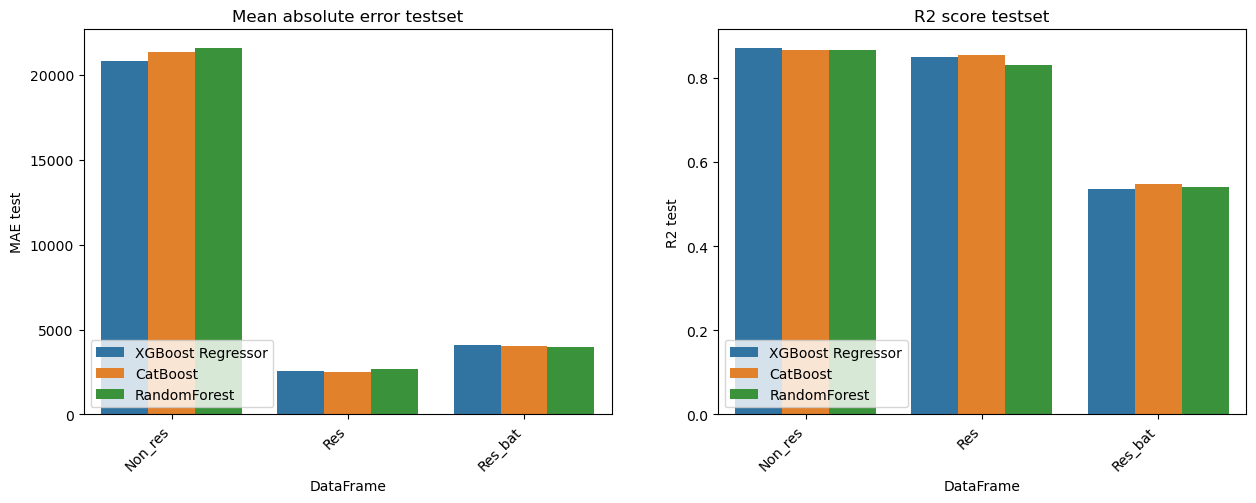

In [111]:
# Pudotetaan valitut kolumnit pois

columns_clean = ['expansion_system','multiple_phase_system','tracking', 'ground_mounted','DC_optimizer','micro_inverter','solar_storage_hybrid_inverter','built_in_meter_inverter','tilt', 'azimuth','technology_module']


models_tuned = {"RandomForest": RandomForestRegressor(random_state=random_state),
            "CatBoost":CatBoostRegressor(random_seed = random_state, loss_function='RMSE', eval_metric ="MAE", verbose=False,subsample=0.5,learning_rate=0.3,l2_leaf_reg=10,iterations=1000,depth=10,border_count=200),
            "XGBoost Regressor": XGBRegressor(subsample=0.9,n_estimators=2000, max_depth=6,learning_rate=0.1,colsample_bytree= 0.7,colsample_bylevel=0.9,seed = random_state, tree_method="gpu_hist")           
            }


res_bat_feat_optimized = exception_handling(res_bat.drop(columns=columns_clean),battery=1)
non_res_feat_optimized = exception_handling(non_res.drop(columns=columns_clean))
res_feat_optimized = exception_handling(res.drop(columns=columns_clean))

df_feat_list = {"Res_bat":res_bat_feat_optimized,"Non_res": non_res_feat_optimized,"Res": res_feat_optimized}

scaler_best = RobustScaler()

result_feat_df = pd.DataFrame(columns=result_columns_list)

for df_name, df_feat in df_feat_list.items():

    # Ajetaan eri skaalaajat evaluate_models funktion läpi    

    data = evaluate_models(df_name,df_feat,scaler_best,models_tuned)
    result_feat_df = result_feat_df.append(data).sort_values(["MAE test"],ascending=True)  

    

df_final = result_feat_df.sort_values("DataFrame")

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Mean absolute error testset")
sns.barplot(data=df_final,x ="DataFrame", y="MAE test",hue="Model")
plt.xticks(rotation=45,ha="right")
plt.legend(loc='lower left')
plt.subplot(1,2,2)
plt.title("R2 score testset")
sns.barplot(data=df_final,x ="DataFrame", y="R2 test",hue="Model")
plt.xticks(rotation=45,ha="right")
plt.legend(loc='lower left')
plt.show()

In [112]:
result_feat_df

,DataFrame,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
1,Res,CatBoost,RobustScaler(),3437.696282,4094.531261,0.898096,0.855132,2143.007580,2515.769458
2,Res,XGBoost Regressor,RobustScaler(),3599.986754,4163.240034,0.888247,0.850229,2265.080588,2578.939991
0,Res,RandomForest,RobustScaler(),1737.095843,4437.873047,0.973980,0.829818,1032.944780,2670.759991
0,Res_bat,RandomForest,RobustScaler(),2391.575792,6200.897022,0.932995,0.541006,1486.566110,3953.734810
1,Res_bat,CatBoost,RobustScaler(),755.433298,6149.148119,0.993315,0.548635,422.316491,4004.569295
2,Res_bat,XGBoost Regressor,RobustScaler(),540.260603,6231.088483,0.996581,0.536525,173.721520,4087.485450
2,Non_res,XGBoost Regressor,RobustScaler(),2149.362666,40246.765688,0.999609,0.871354,389.938014,20799.971377
1,Non_res,CatBoost,RobustScaler(),2318.523485,41006.884340,0.999545,0.866449,772.392270,21366.363710
0,Non_res,RandomForest,RobustScaler(),14471.754974,40926.138156,0.982287,0.866974,8072.015775,21601.274153


#### Analyysi sarakkeiden pudottamista
Sarakkeiden optimoinnin jälkeen Res-datasetissä ennustusten tarkkuuteen tuli pieniä muutoksia. CatBoostin MAE test laski 10 ja muilla nousi.
Res_batissa CatBoostin tulos parani n. 60, muilla laski.
Non_res-datasetissä kaikkien tulos huononi.

Sarakkeiden pudottamisella tavoiteltua ylioppimisen vähentämistä ei merkittävästi tapahtunut, mutta kuitenki saatiin hieman parempi lopputulos ainakin CatBoost-algoritmille. Tämä on ihan loogista, koska pudotetuilla sarakkeilla ei ollut alunperinkään vaikutusta loppuhintaan.


In [113]:
# Tässä solussa tulostetaan vertain vuoksi aikaisempien datasettien tulokset RobustScalerilla
df_vertailu = pd.DataFrame(columns=result_columns_list)

dataframe_list_rest = [res_bat_result_optimal, non_res_result_optimized, res_result_optimized]

dataframe_list_rdf = [res_bat_result, non_res_result, res_result]

for dataframe_name in dataframe_list_rest:

    df_vertailu = df_vertailu.append(dataframe_name[(dataframe_name["Scaler"] == "RobustScaler()") & (dataframe_name["Model"] != "RandomForest")]) 

for dataframe_name in dataframe_list_rdf:

    df_vertailu = df_vertailu.append(dataframe_name[(dataframe_name["Scaler"] == "RobustScaler()") & (dataframe_name["Model"] == "RandomForest")])       

df_vertailu.sort_values(["MAE test"],ascending=True)

,DataFrame,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
1,Res_tuned,CatBoost,RobustScaler(),3307.404462,4095.947372,0.905674,0.855032,2081.172685,2525.938087
2,Res_tuned,XGBoost Regressor,RobustScaler(),3495.436588,4142.286727,0.894644,0.851733,2210.780879,2568.467706
0,Res_default,RandomForest,RobustScaler(),1664.171462,4370.363240,0.976119,0.834956,1001.668073,2648.122796
0,Res_bat_default,RandomForest,RobustScaler(),2318.706288,6106.657030,0.937016,0.554851,1442.047709,3898.687254
2,Res_bat_tuned,XGBoost Regressor,RobustScaler(),205.317361,6031.880412,0.999506,0.565686,26.113112,3989.800113
1,Res_bat_tuned,CatBoost,RobustScaler(),263.086507,6060.058813,0.999189,0.561619,112.998535,4065.668934
2,Non_res_tuned,XGBoost Regressor,RobustScaler(),1206.400171,38834.115669,0.999877,0.880226,247.091848,20078.572253
0,Non_res_default,RandomForest,RobustScaler(),14403.240398,40535.236711,0.982454,0.869503,8056.062672,21511.826094
1,Non_res_tuned,CatBoost,RobustScaler(),1312.628319,41246.045135,0.999854,0.864886,445.067562,21860.196524


#### Testi ajo vain kolmella eniten merkitsevällä sarakkeella
- Tällä testillä vain koitetaan onko muilla sarakkeilla yleensäkkään merkitystä lopputulokseen

Alkuperäisen DataFramen koko =  (6005, 4)
Siivotun DataFramen koko =  (4663, 4)
Keskihinta =  33946.46833583525
Alkuperäisen DataFramen koko =  (10743, 4)
Siivotun DataFramen koko =  (7301, 4)
Keskihinta =  96364.63960142445
Alkuperäisen DataFramen koko =  (566899, 4)
Siivotun DataFramen koko =  (526539, 4)
Keskihinta =  24864.824027637023


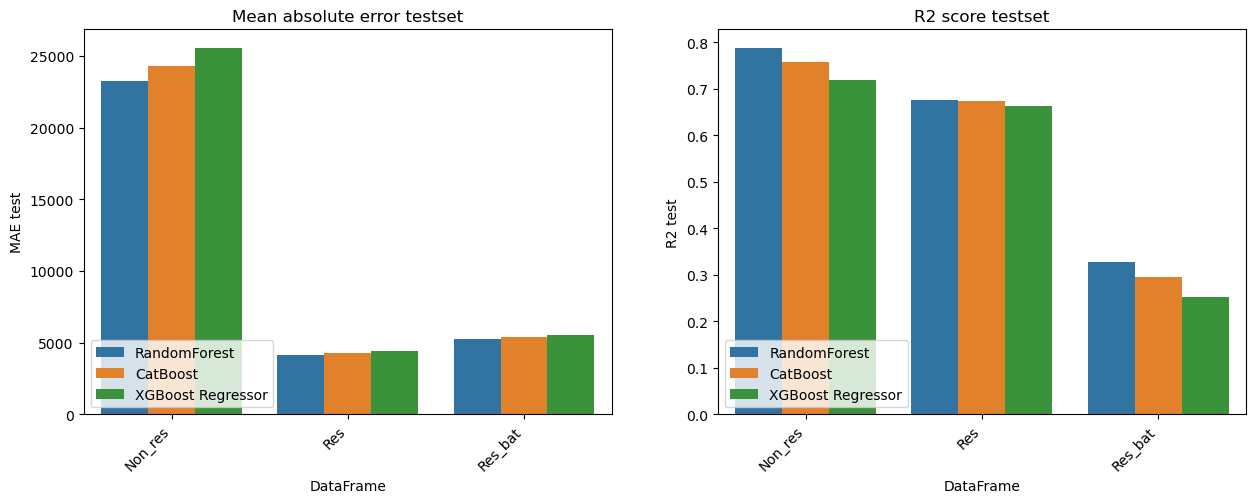

In [116]:
# viimmesenä 3 tärkeintä

models_tuned = {"RandomForest": RandomForestRegressor(random_state=random_state),
            "CatBoost":CatBoostRegressor(random_seed = random_state, loss_function='RMSE', eval_metric ="MAE", verbose=False,subsample=0.5,learning_rate=0.3,l2_leaf_reg=10,iterations=1000,depth=10,border_count=200),
            "XGBoost Regressor": XGBRegressor(subsample=0.9,n_estimators=2000, max_depth=6,learning_rate=0.1,colsample_bytree= 0.7,colsample_bylevel=0.9,seed = random_state, tree_method="gpu_hist")           
            }


res_bat_feat_optimized = exception_handling(res_bat[["module_quantity", "system_size_DC", "inverter_total_capacity","total_installed_price"]], last=1)
non_res_feat_optimized = exception_handling(non_res[["module_quantity", "system_size_DC", "inverter_total_capacity","total_installed_price"]], last=1)
res_feat_optimized = exception_handling(res[["module_quantity", "system_size_DC", "inverter_total_capacity","total_installed_price"]], last=1)

df_feat_list = {"Res_bat":res_bat_feat_optimized,"Non_res": non_res_feat_optimized,"Res": res_feat_optimized}
scaler_best = StandardScaler()

result_feat_df = pd.DataFrame(columns=result_columns_list)

for df_name, df_feat in df_feat_list.items():

    # Ajetaan eri dataframet evaluate_models funktion läpi    

    data = evaluate_models(df_name,df_feat,scaler_best,models_tuned)
    result_feat_df = result_feat_df.append(data).sort_values(["MAE test"],ascending=True)  

    

df_final = result_feat_df.sort_values("DataFrame")

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Mean absolute error testset")
sns.barplot(data=df_final,x ="DataFrame", y="MAE test",hue="Model")
plt.xticks(rotation=45,ha="right")
plt.legend(loc='lower left')
plt.subplot(1,2,2)
plt.title("R2 score testset")
sns.barplot(data=df_final,x ="DataFrame", y="R2 test",hue="Model")
plt.xticks(rotation=45,ha="right")
plt.legend(loc='lower left')
plt.show()

In [117]:
df_final.sort_values(["MAE test"],ascending=True) 

,DataFrame,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
0,Res,RandomForest,StandardScaler(),5459.205719,6187.088309,0.748280,0.676871,3617.841787,4137.582330
1,Res,CatBoost,StandardScaler(),6027.769396,6215.967009,0.693117,0.673848,4137.616564,4256.948426
2,Res,XGBoost Regressor,StandardScaler(),6198.637008,6317.843660,0.675473,0.663069,4323.536740,4401.053896
0,Res_bat,RandomForest,StandardScaler(),4807.591330,7751.189999,0.736258,0.326618,3432.179323,5267.730854
1,Res_bat,CatBoost,StandardScaler(),4683.311404,7924.126635,0.749718,0.296236,3274.380620,5406.252962
2,Res_bat,XGBoost Regressor,StandardScaler(),4718.299739,8162.742558,0.745964,0.253213,3228.763058,5542.652565
0,Non_res,RandomForest,StandardScaler(),17648.990681,41859.612316,0.961791,0.788368,9599.089812,23213.448425
1,Non_res,CatBoost,StandardScaler(),16334.015957,44776.053404,0.967272,0.757851,9865.005014,24296.911962
2,Non_res,XGBoost Regressor,StandardScaler(),19007.515223,48235.140950,0.955682,0.718992,11048.361681,25565.143989


#### Analyysi 
- Kaikilla algortimeillä on huomattavasti huonompi tulos, mitä aikaisemmilla ajoilla, joissa sarakkeita on enemmän mukana.

# Lopputulokset koneoppimisesta

Parhaiden MAE test arvojen vertailu edelliseen vaiheeseen

|DataFrame |Edellinen tulos|Uusi tulos  |
|----------|-----------------|-------------|
|Res_bat   |XGBoost: 3745     |CatBoost 3753 |
|Non_res   |XGBoost: 24529    |XGBoost 20039 |
|Res       |RandomForest: 2813 |CatBoost 2515  |

- Tässä dokumentissä tehdyillä optimoinneilla oli vaikutusta edellisen dokumentin tuloksiin. Res_bat datasetissa saatiin hieman huonompi MAE test arvo, mutta Non_res datasetissa MAE arvo laski huomattavasti ja myös Res-datasetissa MAE tippui mukavasti

- Datasettien piirteillä ja koolla oli merkitystä siihen mikä algoritmi ja mikä scaler antaa parhaan tuloksen eli aina kannattaa kokeilla useampia vaihtoehtoja koneoopimismalleja luodessa.

- Non_res- ja Res-dataseteille saadut n. 0.86 R2-score on mielestämme erittäin hyvä ja MAE arvo saatiin n. 10-15% päähän datasettien keskiarvosta, joka myös on ihan ok tulos. 

- Tämä dokumentti on myös ollut hyvä esimerkki siitä, kuinka vaikeaa ja aikaa vievää pelkästään algoritmeja muokkaamalla on saada parempia ennustuksia.

# Neuroverkot

- Seuraavaksi ajetaan hieman samantyylinen optimointi urakka neuroverkoilla, mitä aikaisemmin tehtiin koneoppimisalgoritmeilla.
- Neuroverkoilla käytossä on Res-dataset

In [182]:
import tensorflow as tf


from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.wrappers.scikit_learn import KerasRegressor

tf.random.set_seed(42)

In [183]:
# Alustetaan DataFrame tuloksia varten
neural_results = pd.DataFrame(columns=["Model name","Total params","Activationfunction","Scaler" ,"Optimizer","Epochs", "Batch size", "RMSE Train", "RMSE Test", "MAE Train", "MAE Test"])


# Käytetään samoja sarakkeita, mitä viimmeisimmässä koneoppimisvaiheessa
res_clean = exception_handling(res.drop(columns=columns_clean))

y = np.array(res_clean["total_installed_price"])
X = np.array(res_clean.drop(columns="total_installed_price"))

# Alustetaan Input arvoksi käytettyjen sarakkeiden määrä
input_shape = (X.shape[1],)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(input_shape)

Alkuperäisen DataFramen koko =  (566899, 15)
Siivotun DataFramen koko =  (509629, 15)
Keskihinta =  24669.68603242413
(379822, 26)
(187077, 26)
(379822,)
(187077,)
(14,)


In [185]:
def deeplearning(info,model, optimizer, epochs, batch_size, callbacks ,scaler, X = X, y = y, verbose=0):


    tulos = pd.DataFrame(columns=["Model name","Total params","Activationfunction","Scaler" ,"Optimizer","Epochs", "Batch size", "RMSE Train", "RMSE Test", "MAE Train", "MAE Test"])


    # Alustetaan omat skaalaajat x:n ja y:n arvoille
    scaler_x = scaler
    scaler_y = scaler

    # skaalataan arvot
    X_scaled = scaler_x.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1,1))

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=random_state) 



    model.compile(loss='mse', 
              optimizer=optimizer, 
              metrics=['mae'])


    hist = model.fit(x=X_train, y=y_train, validation_split = 0.15, epochs=epochs ,batch_size=batch_size ,verbose=verbose, callbacks=[callbacks])

    # Piirretään accuracy/loss kuvaaja
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(hist.history['mae'])
    plt.plot(hist.history['val_mae'])
    plt.title('model accuracy')
    plt.ylabel('mae')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()


    # Ajetaan evaluate funktio train ja test seteille
    results_train = model.evaluate(X_train,y_train,batch_size=batch_size)
    results_test = model.evaluate(X_test,y_test,batch_size=batch_size)

    # Skaalataan arvot takaisin alkuperäiseen skaalaan
    scaled_train = scaler_y.inverse_transform([results_train])
    scaled_test = scaler_y.inverse_transform([results_test])

    rmse_train = scaled_train[0,0]
    rmse_test = scaled_test[0,0]
    mae_train = scaled_train[0,1]
    mae_test = scaled_test[0,1]




    tulos.loc[len(tulos)] = [info[0],info[1], info[2],info[3] ,optimizer, epochs, batch_size, rmse_train, rmse_test, mae_train, mae_test]


    return tulos

In [186]:
# Alustetaan Earlystopping callback, patience arovksi valikoitui 50, ettei ajot keskeydy liian aikaisin
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# Alustetaan default arvot valituille muuttujille
epochs = 200
batch_size = 1024
callback = [early]

#### Määritellään ensimmäinen neuroverkko 
- Käytössä 36865 opetettavaa parametria

In [187]:
# Model 1
activation_func = 'relu'

model = Sequential()
model.add(Dense(256, input_shape=input_shape, activation=activation_func))
model.add(Dense(128, activation=activation_func))
model.add(Dense(1, activation="linear"))

model.summary()


Model_name = "Model 1"
params = model.count_params()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 256)               3840      
                                                                 
 dense_40 (Dense)            (None, 128)               32896     
                                                                 
 dense_41 (Dense)            (None, 1)                 129       
                                                                 
Total params: 36,865
Trainable params: 36,865
Non-trainable params: 0
_________________________________________________________________


- Testataan ensimmäisenä mitenkä eri skaalaajat vaikuttavat neuroverkon toimintaan
- Ensimmäisenä testataan MinMaxScaler

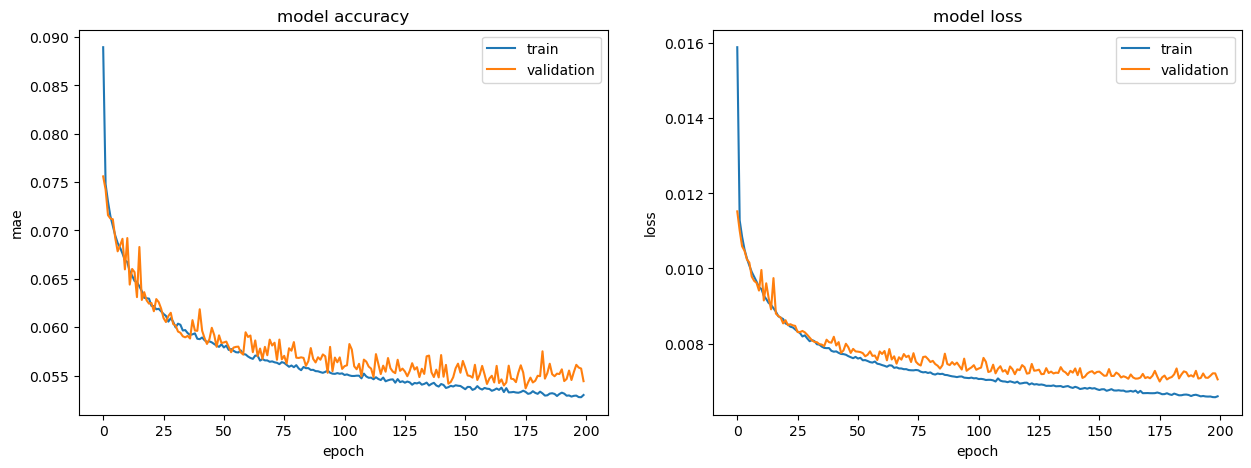

165/165 [==============================] - 0s 1ms/step - loss: 0.0070 - mae: 0.0544


,Model name,Total params,Activationfunction,Scaler,Optimizer,Epochs,Batch size,RMSE Train,RMSE Test,MAE Train,MAE Test
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,1024,1043.385871,1069.70607,3660.249977,3747.99843


In [188]:
scaler=MinMaxScaler()
info = [Model_name, params, activation_func, scaler]
data = deeplearning(info, model, "Adam", epochs, batch_size, callback, scaler=MinMaxScaler())

neural_results = neural_results.append(data)

neural_results


- Ensimmäisen neuroverkon MAE 3747 on aika kaukana koneoppimismalleilla saatuihin tuloksiin. 
- ROC-kuvaajassa validation data ei pysy train datan tahdissa, mutta malli ei silti näytä olevan ylioppinut, koska RMSE train ja test pysyvät melko lähellä toisiaan. Samoin myös MAE train ja test. 
- Validointi datan pieni koko verrattuna train settiin saattaa olla syynä outoon käyttäytymiseen ROC-käyrässä

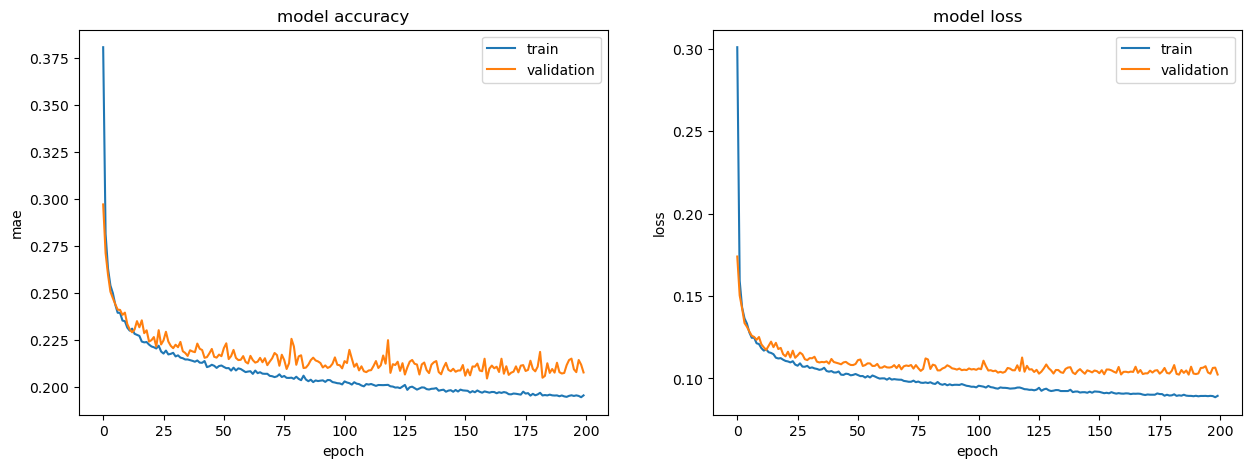

165/165 [==============================] - 0s 1ms/step - loss: 0.1021 - mae: 0.2068


,Model name,Total params,Activationfunction,Scaler,Optimizer,Epochs,Batch size,RMSE Train,RMSE Test,MAE Train,MAE Test
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,1024,1043.385871,1069.706070,3660.249977,3747.998430
0,Model 1,36865,relu,RobustScaler(),Adam,200,1024,24999.599064,25183.800139,26554.653887,26719.344828


In [189]:
scaler=RobustScaler()
info = [Model_name, params, activation_func, scaler]
data = deeplearning(info, model, "Adam", epochs, batch_size, callback, scaler=RobustScaler())

neural_results = neural_results.append(data)

neural_results

- RobustScaler sai huomattavasti paljon huonommat arvot verrattuna MinMaxScaleriin()
- ROC-käyrät ovat melkein identtiset MinMaxscaleriin verrattuna

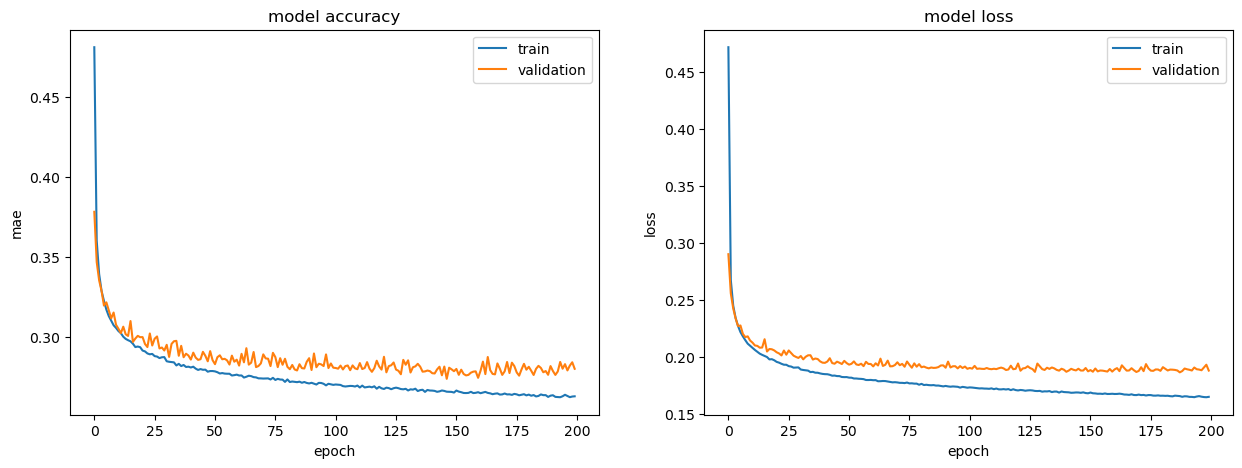

165/165 [==============================] - 0s 1ms/step - loss: 0.1853 - mae: 0.2785


,Model name,Total params,Activationfunction,Scaler,Optimizer,Epochs,Batch size,RMSE Train,RMSE Test,MAE Train,MAE Test
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,1024,1043.385871,1069.706070,3660.249977,3747.998430
0,Model 1,36865,relu,RobustScaler(),Adam,200,1024,24999.599064,25183.800139,26554.653887,26719.344828
0,Model 1,36865,relu,StandardScaler(),Adam,200,1024,26460.942436,26664.146162,27525.600980,27667.551281


In [190]:
scaler=StandardScaler()
info = [Model_name, params, activation_func, scaler]
data = deeplearning(info, model, "Adam", epochs, batch_size, callback, scaler=StandardScaler())

neural_results = neural_results.append(data)

neural_results

- Myös StandardScaler pärjäsi erittäin huonosti tässä datasetissä.

- Tarkastellaan seuraavaksi eri optimizer-funktioiden vaikutusta lopputulokseen ja käytettän pelkästääm MinMaxScaleria lopuissa ajoissa.

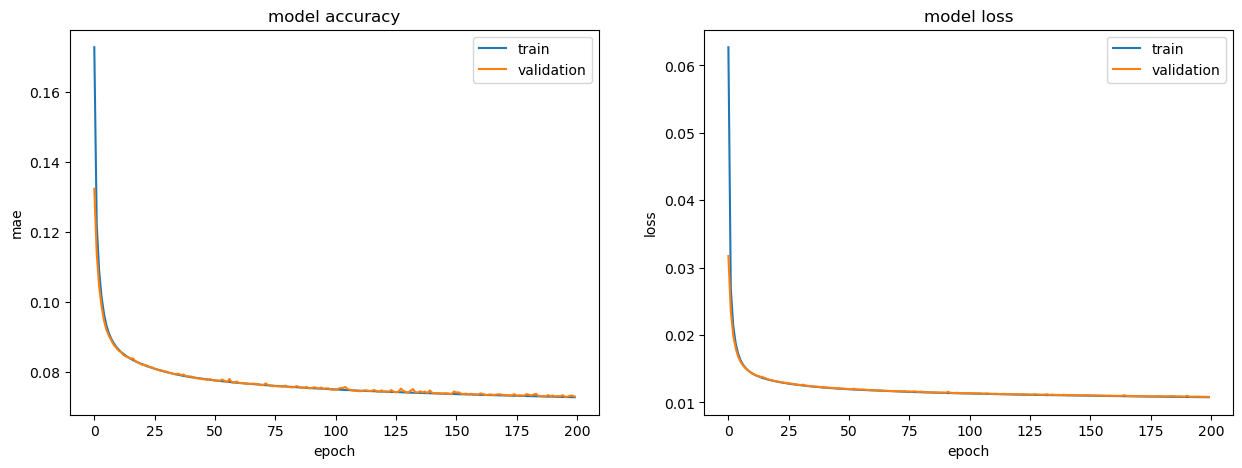

165/165 [==============================] - 0s 1ms/step - loss: 0.0107 - mae: 0.0725


,Model name,Total params,Activationfunction,Scaler,Optimizer,Epochs,Batch size,RMSE Train,RMSE Test,MAE Train,MAE Test
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,1024,1043.385871,1069.706070,3660.249977,3747.998430
0,Model 1,36865,relu,RobustScaler(),Adam,200,1024,24999.599064,25183.800139,26554.653887,26719.344828
0,Model 1,36865,relu,StandardScaler(),Adam,200,1024,26460.942436,26664.146162,27525.600980,27667.551281
0,Model 1,36865,relu,MinMaxScaler(),SGD,200,1024,1280.668686,1273.660406,4793.275096,4775.270096


In [191]:
scaler = MinMaxScaler()


info = [Model_name, params, activation_func, scaler]
data = deeplearning(info, model, "SGD", epochs, batch_size, callback, scaler=scaler)

neural_results = neural_results.append(data)

neural_results

- SGD:n MAE arvot jäivät selvästi Adam optimizerin vastaavasta arvosta
- ROC-Käyrä tosin näyttää melko täydelliseltä ja ehkä epocheja lisäämällä olisi saatu parempi tulos

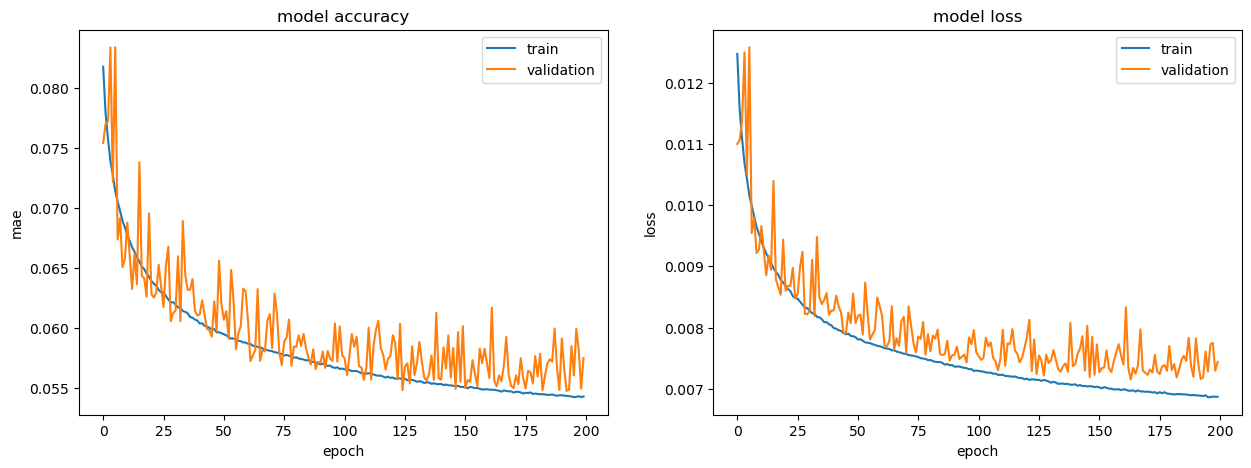

165/165 [==============================] - 0s 1ms/step - loss: 0.0074 - mae: 0.0574


,Model name,Total params,Activationfunction,Scaler,Optimizer,Epochs,Batch size,RMSE Train,RMSE Test,MAE Train,MAE Test
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,1024,1043.385871,1069.706070,3660.249977,3747.998430
0,Model 1,36865,relu,RobustScaler(),Adam,200,1024,24999.599064,25183.800139,26554.653887,26719.344828
0,Model 1,36865,relu,StandardScaler(),Adam,200,1024,26460.942436,26664.146162,27525.600980,27667.551281
0,Model 1,36865,relu,MinMaxScaler(),SGD,200,1024,1280.668686,1273.660406,4793.275096,4775.270096
0,Model 1,36865,relu,MinMaxScaler(),RMSprop,200,1024,1071.408925,1090.322143,3859.356738,3918.830739


In [192]:
info = [Model_name, params, activation_func, scaler]
data = deeplearning(info, model, "RMSprop", epochs, batch_size, callback, scaler=scaler)

neural_results = neural_results.append(data)

neural_results

- RMSprop-pärjäsi hieman paremmin, kuin SGD, mutta jäi silti selvästä Adam:ista
- Myös ROC-käyrässä näkyvä validation arvojen suuri vaihtelu ei ole toivottavaa

- Koitetaan seuraavaksi eri aktivointi-funktioiden vaikutusta lopputulokseen ja jatkossa käytetään vain Adam-optimoijaa
- Ensimmäisenä käyttöön "elu", joka on Exponential Linear Unit. Toisin kuin "ReLU" "elu" voi saada myös negatiivisia arvoja, mutta on muuten laskennallisesti yksinkertaisempi.

In [193]:
# Model 1

activation_func = 'elu'
model = Sequential()
model.add(Dense(256, input_shape=input_shape, activation=activation_func))
model.add(Dense(128, activation=activation_func))
model.add(Dense(1, activation="linear"))

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 256)               3840      
                                                                 
 dense_43 (Dense)            (None, 128)               32896     
                                                                 
 dense_44 (Dense)            (None, 1)                 129       
                                                                 
Total params: 36,865
Trainable params: 36,865
Non-trainable params: 0
_________________________________________________________________


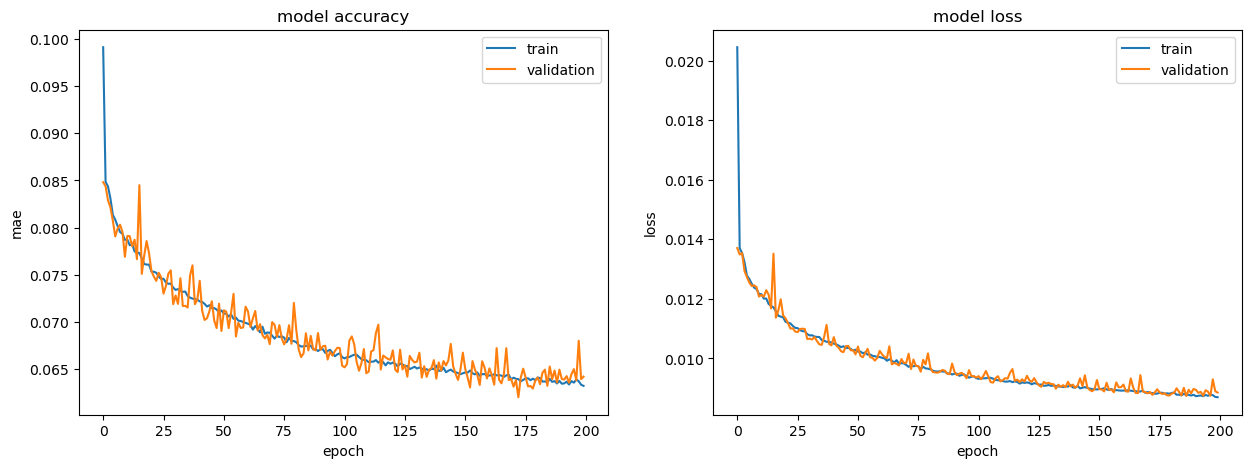

165/165 [==============================] - 0s 2ms/step - loss: 0.0087 - mae: 0.0638


,Model name,Total params,Activationfunction,Scaler,Optimizer,Epochs,Batch size,RMSE Train,RMSE Test,MAE Train,MAE Test
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,1024,1043.385871,1069.706070,3660.249977,3747.998430
0,Model 1,36865,relu,RobustScaler(),Adam,200,1024,24999.599064,25183.800139,26554.653887,26719.344828
0,Model 1,36865,relu,StandardScaler(),Adam,200,1024,26460.942436,26664.146162,27525.600980,27667.551281
0,Model 1,36865,relu,MinMaxScaler(),SGD,200,1024,1280.668686,1273.660406,4793.275096,4775.270096
0,Model 1,36865,relu,MinMaxScaler(),RMSprop,200,1024,1071.408925,1090.322143,3859.356738,3918.830739
0,Model 1,36865,elu,MinMaxScaler(),Adam,200,1024,1166.633256,1165.450877,4285.554900,4279.300869


In [194]:
info = [Model_name, params, activation_func, scaler]
data = deeplearning(info, model, "Adam", epochs, batch_size, callback, scaler=scaler)

neural_results = neural_results.append(data)

neural_results

- "ReLU" aktivointi funktiota käyttäen saatiin parempi tulos.
- Seuraavana hyperbolinen tangetti activointi funktio

In [195]:
# Model 1

activation_func = "tanh"
model = Sequential()
model.add(Dense(256, input_shape=input_shape, activation=activation_func))
model.add(Dense(128, activation=activation_func))
model.add(Dense(1, activation="linear"))

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 256)               3840      
                                                                 
 dense_46 (Dense)            (None, 128)               32896     
                                                                 
 dense_47 (Dense)            (None, 1)                 129       
                                                                 
Total params: 36,865
Trainable params: 36,865
Non-trainable params: 0
_________________________________________________________________


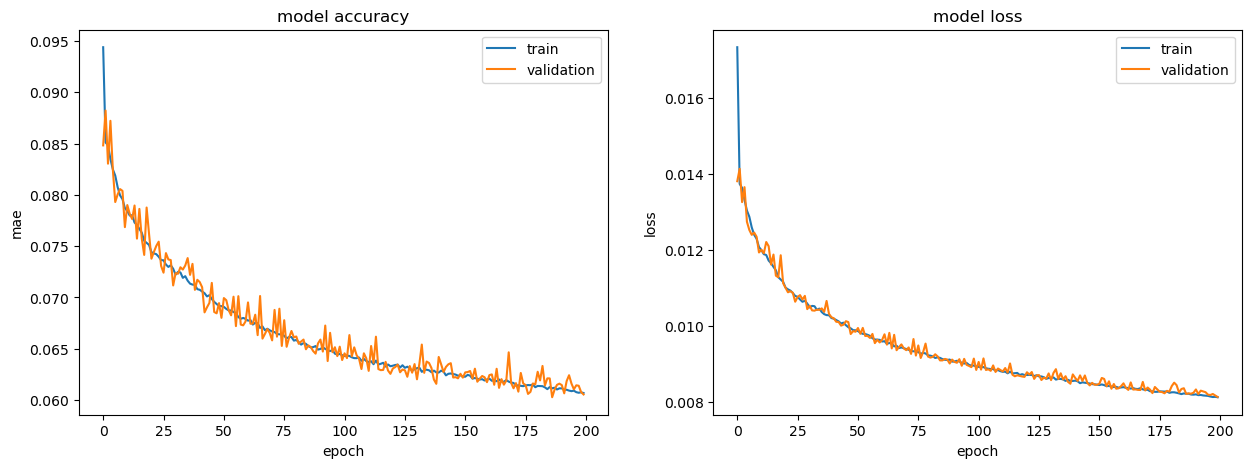

165/165 [==============================] - 0s 2ms/step - loss: 0.0081 - mae: 0.0602


,Model name,Total params,Activationfunction,Scaler,Optimizer,Epochs,Batch size,RMSE Train,RMSE Test,MAE Train,MAE Test
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,1024,1043.385871,1069.706070,3660.249977,3747.998430
0,Model 1,36865,relu,RobustScaler(),Adam,200,1024,24999.599064,25183.800139,26554.653887,26719.344828
0,Model 1,36865,relu,StandardScaler(),Adam,200,1024,26460.942436,26664.146162,27525.600980,27667.551281
0,Model 1,36865,relu,MinMaxScaler(),SGD,200,1024,1280.668686,1273.660406,4793.275096,4775.270096
0,Model 1,36865,relu,MinMaxScaler(),RMSprop,200,1024,1071.408925,1090.322143,3859.356738,3918.830739
0,Model 1,36865,elu,MinMaxScaler(),Adam,200,1024,1166.633256,1165.450877,4285.554900,4279.300869
0,Model 1,36865,tanh,MinMaxScaler(),Adam,200,1024,1128.226564,1127.745002,4079.782681,4074.268670


In [196]:
info = [Model_name, params, activation_func, scaler]

data = deeplearning(info, model, "Adam", epochs, batch_size, callback, scaler=scaler)

neural_results = neural_results.append(data)

neural_results

- "tanh" funktio pärjäsi hieman paremmin, kuin "elu",mutta silti huonommin, kuin "ReLU", mitä käytetään lopuissa ajoissa.

In [203]:
# Model 1
activation_func = 'relu'

model = Sequential()
model.add(Dense(256, input_shape=input_shape, activation=activation_func))
model.add(Dense(128, activation=activation_func))
model.add(Dense(1, activation="linear"))

model.summary()


Model_name = "Model 1"
params = model.count_params()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 256)               3840      
                                                                 
 dense_55 (Dense)            (None, 128)               32896     
                                                                 
 dense_56 (Dense)            (None, 1)                 129       
                                                                 
Total params: 36,865
Trainable params: 36,865
Non-trainable params: 0
_________________________________________________________________


- Vertaillaan seuraavaksi, kuin batch size vaikuttaa lopputulokseen.

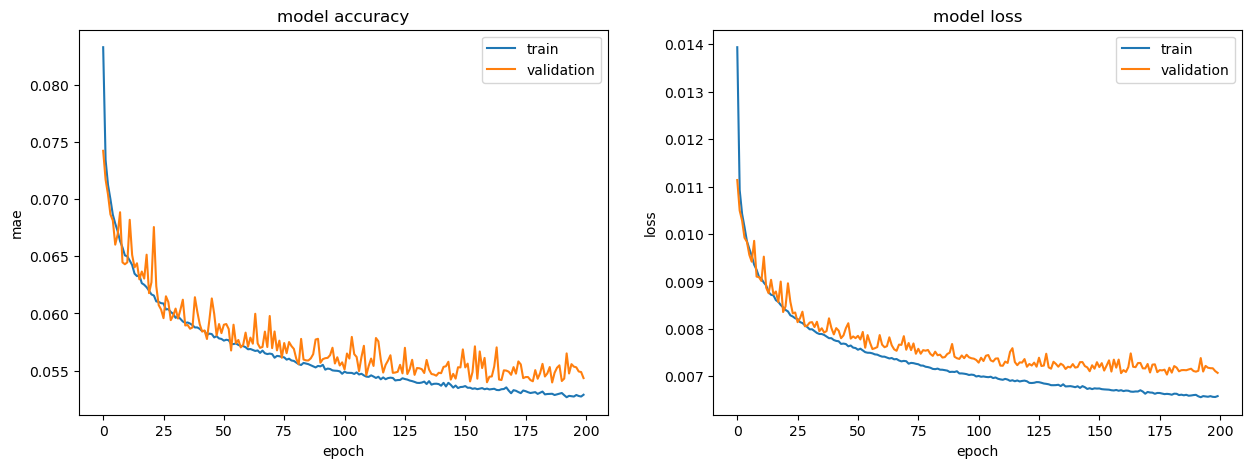

329/329 [==============================] - 1s 2ms/step - loss: 0.0070 - mae: 0.0541


,Model name,Total params,Activationfunction,Scaler,Optimizer,Epochs,Batch size,RMSE Train,RMSE Test,MAE Train,MAE Test
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,1024,1043.385871,1069.706070,3660.249977,3747.998430
0,Model 1,36865,relu,RobustScaler(),Adam,200,1024,24999.599064,25183.800139,26554.653887,26719.344828
0,Model 1,36865,relu,StandardScaler(),Adam,200,1024,26460.942436,26664.146162,27525.600980,27667.551281
0,Model 1,36865,relu,MinMaxScaler(),SGD,200,1024,1280.668686,1273.660406,4793.275096,4775.270096
0,Model 1,36865,relu,MinMaxScaler(),RMSprop,200,1024,1071.408925,1090.322143,3859.356738,3918.830739
0,Model 1,36865,elu,MinMaxScaler(),Adam,200,1024,1166.633256,1165.450877,4285.554900,4279.300869
0,Model 1,36865,tanh,MinMaxScaler(),Adam,200,1024,1128.226564,1127.745002,4079.782681,4074.268670
0,Model1,36865,relu,MinMaxScaler(),Adam,200,512,1042.498625,1068.421493,3645.769297,3731.838108


In [198]:
Model_name = "Model 1"
callback = [early]
info = [Model_name, params, activation_func, scaler]

batch_size = 512

data = deeplearning(info, model, "Adam", epochs, batch_size, callback, scaler=scaler)

neural_results = neural_results.append(data)

neural_results

Restoring model weights from the end of the best epoch: 126.
Epoch 176: early stopping


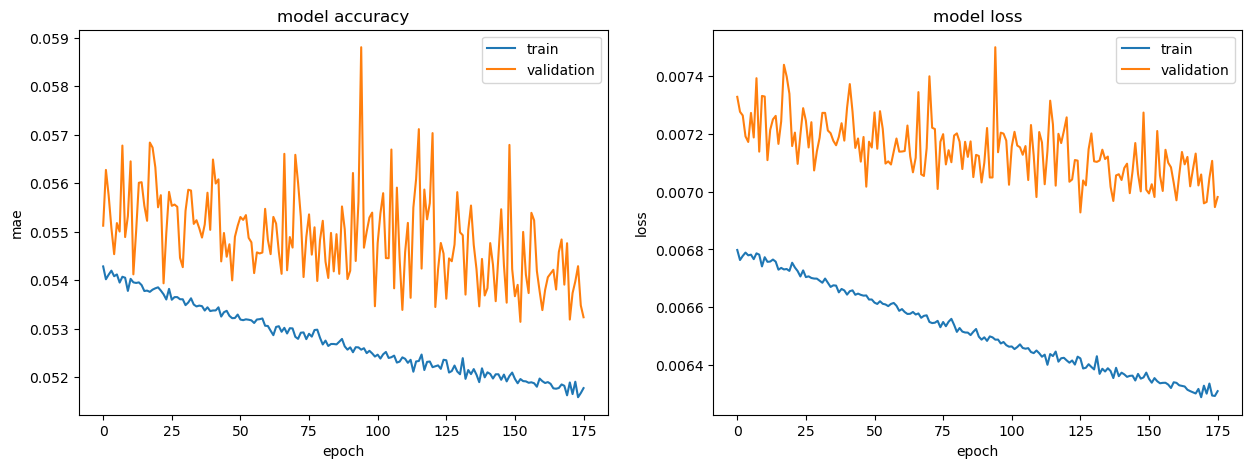

657/657 [==============================] - 1s 1ms/step - loss: 0.0069 - mae: 0.0536


,Model name,Total params,Activationfunction,Scaler,Optimizer,Epochs,Batch size,RMSE Train,RMSE Test,MAE Train,MAE Test
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,1024,1043.385871,1069.706070,3660.249977,3747.998430
0,Model 1,36865,relu,RobustScaler(),Adam,200,1024,24999.599064,25183.800139,26554.653887,26719.344828
0,Model 1,36865,relu,StandardScaler(),Adam,200,1024,26460.942436,26664.146162,27525.600980,27667.551281
0,Model 1,36865,relu,MinMaxScaler(),SGD,200,1024,1280.668686,1273.660406,4793.275096,4775.270096
0,Model 1,36865,relu,MinMaxScaler(),RMSprop,200,1024,1071.408925,1090.322143,3859.356738,3918.830739
0,Model 1,36865,elu,MinMaxScaler(),Adam,200,1024,1166.633256,1165.450877,4285.554900,4279.300869
0,Model 1,36865,tanh,MinMaxScaler(),Adam,200,1024,1128.226564,1127.745002,4079.782681,4074.268670
0,Model1,36865,relu,MinMaxScaler(),Adam,200,512,1042.498625,1068.421493,3645.769297,3731.838108
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,256,1027.677259,1062.102148,3589.121962,3706.280297


In [199]:
Model_name = "Model 1"
info = [Model_name, params, activation_func, scaler]

batch_size = 256

data = deeplearning(info, model, "Adam", epochs, batch_size, callback, scaler=scaler)

neural_results = neural_results.append(data)

neural_results

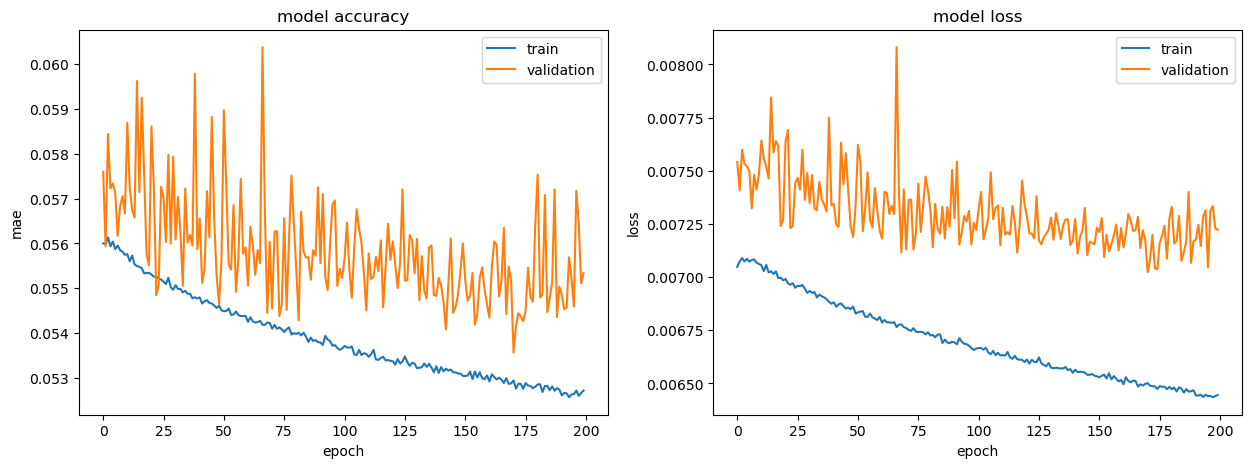

2628/2628 [==============================] - 4s 2ms/step - loss: 0.0072 - mae: 0.0552


,Model name,Total params,Activationfunction,Scaler,Optimizer,Epochs,Batch size,RMSE Train,RMSE Test,MAE Train,MAE Test
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,1024,1043.385871,1069.706070,3660.249977,3747.998430
0,Model 1,36865,relu,RobustScaler(),Adam,200,1024,24999.599064,25183.800139,26554.653887,26719.344828
0,Model 1,36865,relu,StandardScaler(),Adam,200,1024,26460.942436,26664.146162,27525.600980,27667.551281
0,Model 1,36865,relu,MinMaxScaler(),SGD,200,1024,1280.668686,1273.660406,4793.275096,4775.270096
0,Model 1,36865,relu,MinMaxScaler(),RMSprop,200,1024,1071.408925,1090.322143,3859.356738,3918.830739
0,Model 1,36865,elu,MinMaxScaler(),Adam,200,1024,1166.633256,1165.450877,4285.554900,4279.300869
0,Model 1,36865,tanh,MinMaxScaler(),Adam,200,1024,1128.226564,1127.745002,4079.782681,4074.268670
0,Model1,36865,relu,MinMaxScaler(),Adam,200,512,1042.498625,1068.421493,3645.769297,3731.838108
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,256,1027.677259,1062.102148,3589.121962,3706.280297
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,64,1042.670484,1078.163909,3676.699058,3796.029189


In [200]:
Model_name = "Model 1"

info = [Model_name, params, activation_func, scaler]

batch_size = 64

data = deeplearning(info, model, "Adam", epochs, batch_size, callback, scaler=scaler)

neural_results = neural_results.append(data)

neural_results

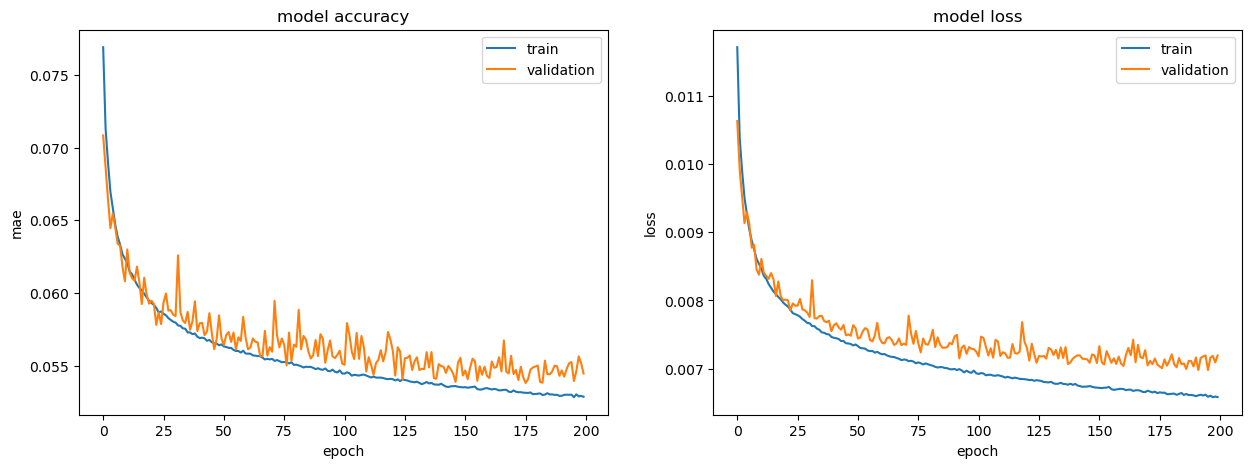

1314/1314 [==============================] - 2s 2ms/step - loss: 0.0072 - mae: 0.0544


,Model name,Total params,Activationfunction,Scaler,Optimizer,Epochs,Batch size,RMSE Train,RMSE Test,MAE Train,MAE Test
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,1024,1043.385871,1069.706070,3660.249977,3747.998430
0,Model 1,36865,relu,RobustScaler(),Adam,200,1024,24999.599064,25183.800139,26554.653887,26719.344828
0,Model 1,36865,relu,StandardScaler(),Adam,200,1024,26460.942436,26664.146162,27525.600980,27667.551281
0,Model 1,36865,relu,MinMaxScaler(),SGD,200,1024,1280.668686,1273.660406,4793.275096,4775.270096
0,Model 1,36865,relu,MinMaxScaler(),RMSprop,200,1024,1071.408925,1090.322143,3859.356738,3918.830739
0,Model 1,36865,elu,MinMaxScaler(),Adam,200,1024,1166.633256,1165.450877,4285.554900,4279.300869
0,Model 1,36865,tanh,MinMaxScaler(),Adam,200,1024,1128.226564,1127.745002,4079.782681,4074.268670
0,Model1,36865,relu,MinMaxScaler(),Adam,200,512,1042.498625,1068.421493,3645.769297,3731.838108
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,256,1027.677259,1062.102148,3589.121962,3706.280297
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,64,1042.670484,1078.163909,3676.699058,3796.029189


In [204]:
Model_name = "Model 1"

info = [Model_name, params, activation_func, scaler]

batch_size = 128

data = deeplearning(info, model, "Adam", epochs, batch_size, callback, scaler=scaler)

neural_results = neural_results.append(data)

neural_results

- Batch sizen muuttamisella oli suuri vaikutus MAE-test arvoon. Optimaalisin batch size arvo tällä datasetillä ja mallilla näyttäisi olevan 256.
- Batch sizen pienentäminen aiheutti ROC-käyrässä validointi lossin ja MAE:N etääntymisen vastaavista train loss ja MAE arvoista.
- Mielenkiintoista tässä on se, että batch size 256:lla ajettaessa ROC-käyrä näyttää erittäin huonolta, mutta se silti sai parhaimman MAE test arvon. Tämä saattaa johtua siitä, että kyseisellä ajolla earlystoppin pysäytti ajon kesken ja palautti parhaimman arvon.

- Lisätään malliin Dropout-kerros

In [210]:
# Model 1
activation_func = 'relu'

model = Sequential()
model.add(Dense(256, input_shape=input_shape, activation=activation_func))
model.add(Dropout(0.5))
model.add(Dense(128, activation=activation_func ))
model.add(Dense(1, activation="linear"))

model.summary()


Model_name = "Model 1 + Dropout"
params = model.count_params()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_69 (Dense)            (None, 256)               3840      
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_70 (Dense)            (None, 128)               32896     
                                                                 
 dense_71 (Dense)            (None, 1)                 129       
                                                                 
Total params: 36,865
Trainable params: 36,865
Non-trainable params: 0
_________________________________________________________________


Restoring model weights from the end of the best epoch: 22.
Epoch 72: early stopping


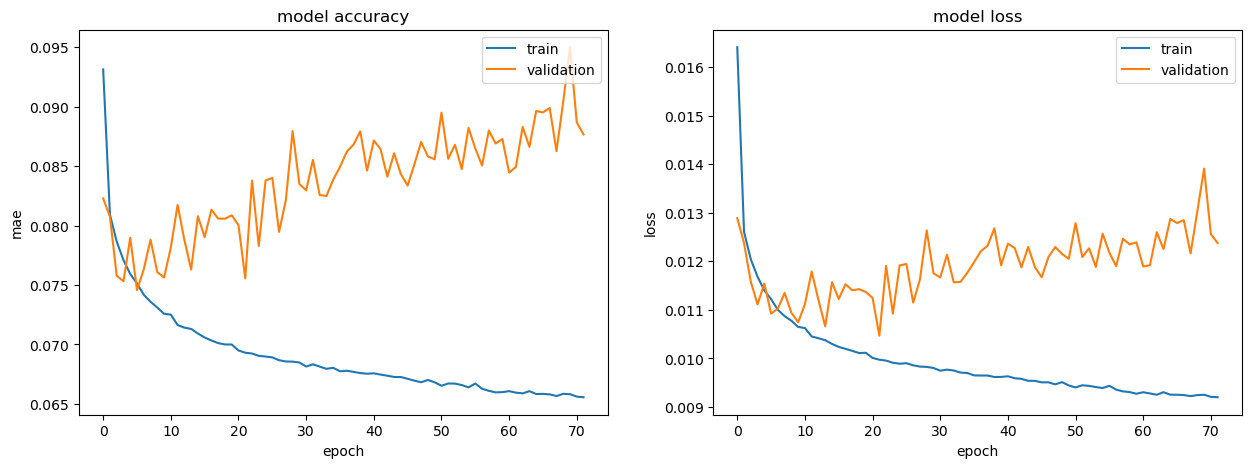

657/657 [==============================] - 1s 2ms/step - loss: 0.0103 - mae: 0.0753


,Model name,Total params,Activationfunction,Scaler,Optimizer,Epochs,Batch size,RMSE Train,RMSE Test,MAE Train,MAE Test
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,1024,1043.385871,1069.706070,3660.249977,3747.998430
0,Model 1,36865,relu,RobustScaler(),Adam,200,1024,24999.599064,25183.800139,26554.653887,26719.344828
0,Model 1,36865,relu,StandardScaler(),Adam,200,1024,26460.942436,26664.146162,27525.600980,27667.551281
0,Model 1,36865,relu,MinMaxScaler(),SGD,200,1024,1280.668686,1273.660406,4793.275096,4775.270096
0,Model 1,36865,relu,MinMaxScaler(),RMSprop,200,1024,1071.408925,1090.322143,3859.356738,3918.830739
0,Model 1,36865,elu,MinMaxScaler(),Adam,200,1024,1166.633256,1165.450877,4285.554900,4279.300869
0,Model 1,36865,tanh,MinMaxScaler(),Adam,200,1024,1128.226564,1127.745002,4079.782681,4074.268670
0,Model1,36865,relu,MinMaxScaler(),Adam,200,512,1042.498625,1068.421493,3645.769297,3731.838108
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,256,1027.677259,1062.102148,3589.121962,3706.280297
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,64,1042.670484,1078.163909,3676.699058,3796.029189


In [211]:
info = [Model_name, params, activation_func, scaler]

batch_size = 256

data = deeplearning(info, model, "Adam", epochs, batch_size, callback, scaler=scaler)

neural_results = neural_results.append(data)

neural_results

- Dropout kerroksen lisääminen huononsi merkittävästä MAE-test arvoa ja aiheutti ROC-käyrässä validointi datan suuremman erkanemisen Train lossista ja mae:sta

### Verkko numero 2
- Lasketaan verkon koko käyttämällä kaavaa: ```Training Data Samples / (Factor * (Input Neurons + Output Neurons))```


In [212]:
# Lasketaan arvot kaavan mukaan
sample_size = X.shape[0]
factor = 1
io_neurons = X.shape[1] + 1

size = round(sample_size/(factor*io_neurons))

activation_func = 'relu'
# Model 2
model = Sequential()

model.add(Dense(size, input_shape=input_shape, activation='relu'))
model.add(Dense(1, activation="linear"))

model.summary()

params = model.count_params()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 33975)             509625    
                                                                 
 dense_73 (Dense)            (None, 1)                 33976     
                                                                 
Total params: 543,601
Trainable params: 543,601
Non-trainable params: 0
_________________________________________________________________


543601

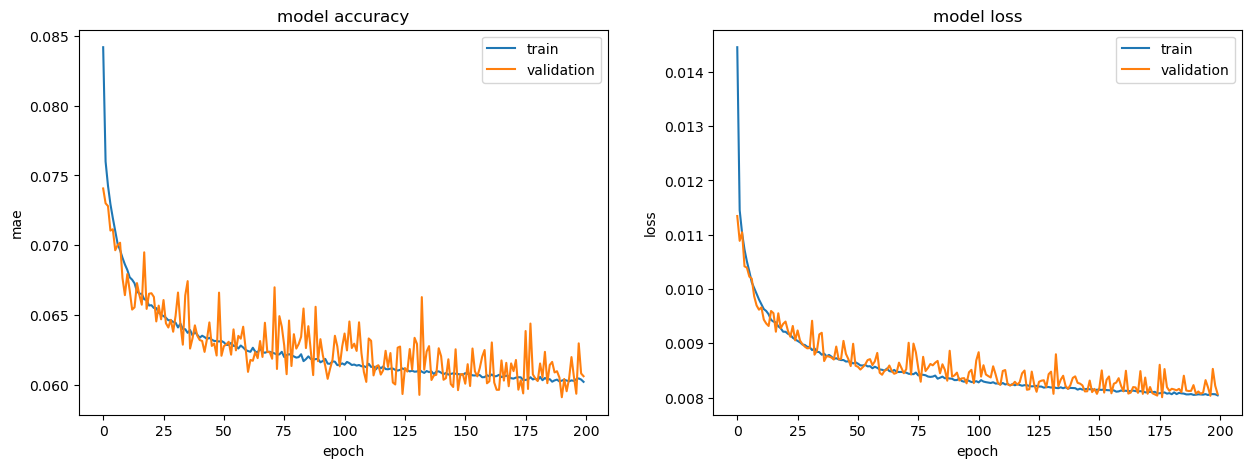

657/657 [==============================] - 1s 2ms/step - loss: 0.0080 - mae: 0.0603


,Model name,Total params,Activationfunction,Scaler,Optimizer,Epochs,Batch size,RMSE Train,RMSE Test,MAE Train,MAE Test
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,1024,1043.385871,1069.706070,3660.249977,3747.998430
0,Model 1,36865,relu,RobustScaler(),Adam,200,1024,24999.599064,25183.800139,26554.653887,26719.344828
0,Model 1,36865,relu,StandardScaler(),Adam,200,1024,26460.942436,26664.146162,27525.600980,27667.551281
0,Model 1,36865,relu,MinMaxScaler(),SGD,200,1024,1280.668686,1273.660406,4793.275096,4775.270096
0,Model 1,36865,relu,MinMaxScaler(),RMSprop,200,1024,1071.408925,1090.322143,3859.356738,3918.830739
0,Model 1,36865,elu,MinMaxScaler(),Adam,200,1024,1166.633256,1165.450877,4285.554900,4279.300869
0,Model 1,36865,tanh,MinMaxScaler(),Adam,200,1024,1128.226564,1127.745002,4079.782681,4074.268670
0,Model1,36865,relu,MinMaxScaler(),Adam,200,512,1042.498625,1068.421493,3645.769297,3731.838108
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,256,1027.677259,1062.102148,3589.121962,3706.280297
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,64,1042.670484,1078.163909,3676.699058,3796.029189


In [213]:
Model_name = "Model 2"
batch_size = 256

info = [Model_name, params, activation_func, scaler]

data = deeplearning(info, model, "Adam", epochs, batch_size, callback, scaler=scaler)
neural_results = neural_results.append(data)

neural_results

- Model 2 on kooltaan huomattavasti suurempi, mitä aikaisemmat mallit. Tässä käytössä 543,601 parametria. Model 2 sisältää vain yhden Dense kerroksen.
- Mallin koon suurentaminen ei vaikuttanut positiivisesti lopputulokseen.

In [219]:
sample_size = X.shape[0]
factor = 10
io_neurons = X.shape[1] + 1

size = round(sample_size/(factor*io_neurons))
factor = 10
size2 = round(sample_size/(factor*io_neurons))



# Model 3
model = Sequential()

model.add(Dense(size, input_shape=input_shape, activation='relu'))
model.add(Dense(size2, activation='relu'))
model.add(Dense(1, activation="linear"))

model.summary()

params = model.count_params()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_86 (Dense)            (None, 3398)              50970     
                                                                 
 dense_87 (Dense)            (None, 3398)              11549802  
                                                                 
 dense_88 (Dense)            (None, 1)                 3399      
                                                                 
Total params: 11,604,171
Trainable params: 11,604,171
Non-trainable params: 0
_________________________________________________________________


Restoring model weights from the end of the best epoch: 27.
Epoch 77: early stopping


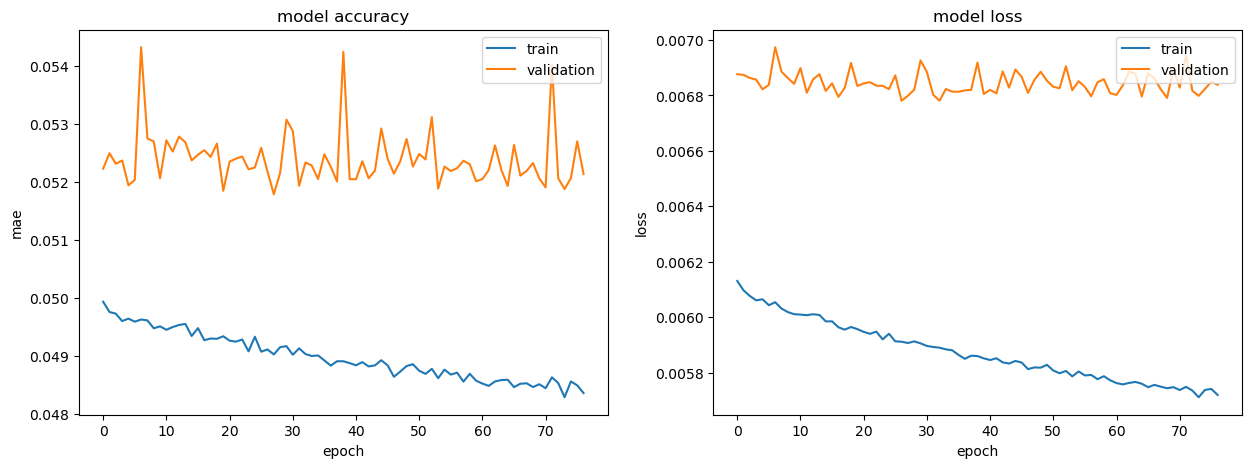

165/165 [==============================] - 1s 4ms/step - loss: 0.0067 - mae: 0.0517


,Model name,Total params,Activationfunction,Scaler,Optimizer,Epochs,Batch size,RMSE Train,RMSE Test,MAE Train,MAE Test
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,1024,1043.385871,1069.706070,3660.249977,3747.998430
0,Model 1,36865,relu,RobustScaler(),Adam,200,1024,24999.599064,25183.800139,26554.653887,26719.344828
0,Model 1,36865,relu,StandardScaler(),Adam,200,1024,26460.942436,26664.146162,27525.600980,27667.551281
0,Model 1,36865,relu,MinMaxScaler(),SGD,200,1024,1280.668686,1273.660406,4793.275096,4775.270096
0,Model 1,36865,relu,MinMaxScaler(),RMSprop,200,1024,1071.408925,1090.322143,3859.356738,3918.830739
0,Model 1,36865,elu,MinMaxScaler(),Adam,200,1024,1166.633256,1165.450877,4285.554900,4279.300869
0,Model 1,36865,tanh,MinMaxScaler(),Adam,200,1024,1128.226564,1127.745002,4079.782681,4074.268670
0,Model1,36865,relu,MinMaxScaler(),Adam,200,512,1042.498625,1068.421493,3645.769297,3731.838108
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,256,1027.677259,1062.102148,3589.121962,3706.280297
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,64,1042.670484,1078.163909,3676.699058,3796.029189


In [222]:
Model_name = "Model 3"
info = [Model_name, params, activation_func, scaler]

epochs = 100
batch_size = 1024

data = deeplearning(info, model, "Adam", epochs, batch_size, callback, scaler=scaler)
neural_results = neural_results.append(data)

neural_results

- Model 3:ssa listätään toinen Dense kerros, jonka koko lasketaan aikaisemmalla kaavalla.
- Tässä mallissa tarkkuus parani huomattavasti aikasempiin nähden, vaikka ROC-käyrä heiluu aivan eri ulottuvuuksissa, mitä train loss/mae. Tosin tässä earlystopping pysäytti ajon epochin 77 kohdalla ja palautti parhaat arvot.

In [225]:
sample_size = X.shape[0]
factor = 10
io_neurons = X.shape[1] + 1

size = round(sample_size/(factor*io_neurons))
factor = 10
size2 = round(sample_size/(factor*io_neurons))



# Model 4
model = Sequential()

model.add(Dense(size, input_shape=input_shape, activation='relu'))
model.add(Dense(size2, activation='relu'))
model.add(Dense(size2, activation='relu'))
model.add(Dense(1, activation="linear"))

model.summary()

params = model.count_params()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_93 (Dense)            (None, 3398)              50970     
                                                                 
 dense_94 (Dense)            (None, 3398)              11549802  
                                                                 
 dense_95 (Dense)            (None, 3398)              11549802  
                                                                 
 dense_96 (Dense)            (None, 1)                 3399      
                                                                 
Total params: 23,153,973
Trainable params: 23,153,973
Non-trainable params: 0
_________________________________________________________________


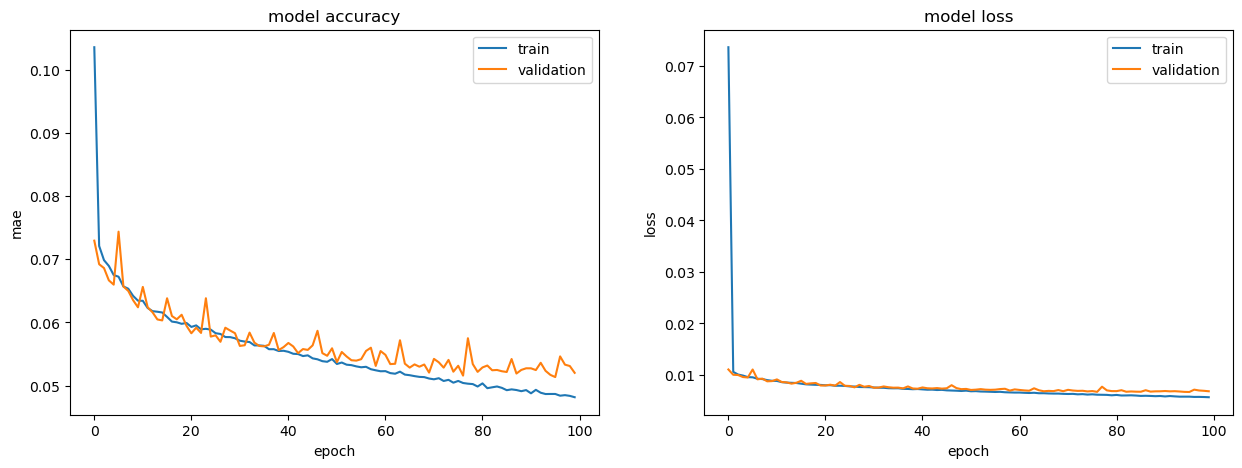

165/165 [==============================] - 1s 7ms/step - loss: 0.0068 - mae: 0.0518


,Model name,Total params,Activationfunction,Scaler,Optimizer,Epochs,Batch size,RMSE Train,RMSE Test,MAE Train,MAE Test
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,1024,1043.385871,1069.706070,3660.249977,3747.998430
0,Model 1,36865,relu,RobustScaler(),Adam,200,1024,24999.599064,25183.800139,26554.653887,26719.344828
0,Model 1,36865,relu,StandardScaler(),Adam,200,1024,26460.942436,26664.146162,27525.600980,27667.551281
0,Model 1,36865,relu,MinMaxScaler(),SGD,200,1024,1280.668686,1273.660406,4793.275096,4775.270096
0,Model 1,36865,relu,MinMaxScaler(),RMSprop,200,1024,1071.408925,1090.322143,3859.356738,3918.830739
0,Model 1,36865,elu,MinMaxScaler(),Adam,200,1024,1166.633256,1165.450877,4285.554900,4279.300869
0,Model 1,36865,tanh,MinMaxScaler(),Adam,200,1024,1128.226564,1127.745002,4079.782681,4074.268670
0,Model1,36865,relu,MinMaxScaler(),Adam,200,512,1042.498625,1068.421493,3645.769297,3731.838108
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,256,1027.677259,1062.102148,3589.121962,3706.280297
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,64,1042.670484,1078.163909,3676.699058,3796.029189


In [224]:
Model_name = "Model 4"
info = [Model_name, params, activation_func, scaler]

epochs = 100
batch_size = 1024

data = deeplearning(info, model, "Adam", epochs, batch_size, callback, scaler=scaler)
neural_results = neural_results.append(data)

neural_results

- Model 4:ssa lisätään vielä Dense kerros. Tällä saavutetaan melkein sama tulos, mitä edellisellä.

Restoring model weights from the end of the best epoch: 102.
Epoch 152: early stopping


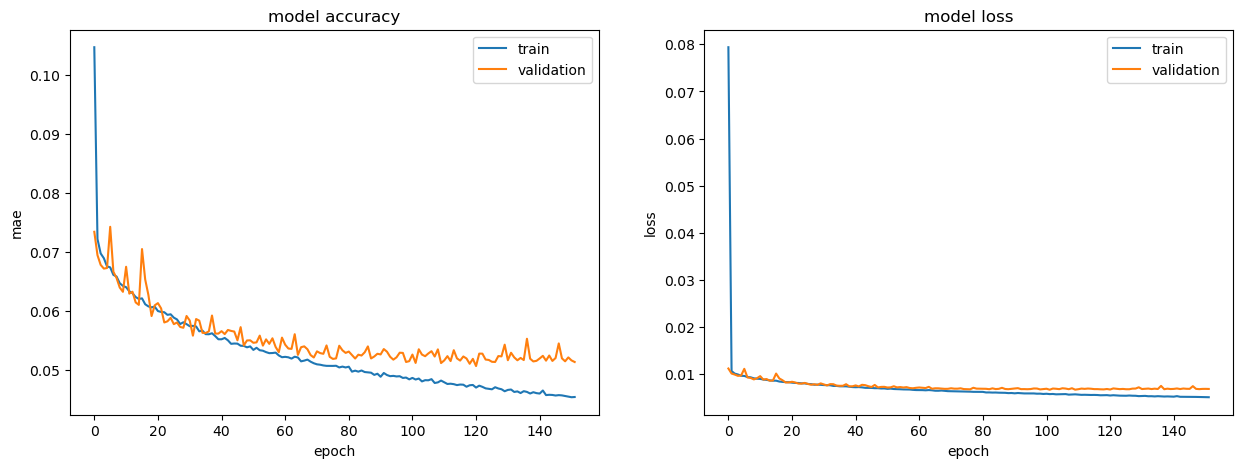

165/165 [==============================] - 1s 7ms/step - loss: 0.0066 - mae: 0.0511


,Model name,Total params,Activationfunction,Scaler,Optimizer,Epochs,Batch size,RMSE Train,RMSE Test,MAE Train,MAE Test
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,1024,1043.385871,1069.706070,3660.249977,3747.998430
0,Model 1,36865,relu,RobustScaler(),Adam,200,1024,24999.599064,25183.800139,26554.653887,26719.344828
0,Model 1,36865,relu,StandardScaler(),Adam,200,1024,26460.942436,26664.146162,27525.600980,27667.551281
0,Model 1,36865,relu,MinMaxScaler(),SGD,200,1024,1280.668686,1273.660406,4793.275096,4775.270096
0,Model 1,36865,relu,MinMaxScaler(),RMSprop,200,1024,1071.408925,1090.322143,3859.356738,3918.830739
0,Model 1,36865,elu,MinMaxScaler(),Adam,200,1024,1166.633256,1165.450877,4285.554900,4279.300869
0,Model 1,36865,tanh,MinMaxScaler(),Adam,200,1024,1128.226564,1127.745002,4079.782681,4074.268670
0,Model1,36865,relu,MinMaxScaler(),Adam,200,512,1042.498625,1068.421493,3645.769297,3731.838108
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,256,1027.677259,1062.102148,3589.121962,3706.280297
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,64,1042.670484,1078.163909,3676.699058,3796.029189


In [226]:
Model_name = "Model 4"
info = [Model_name, params, activation_func, scaler]

epochs = 200
batch_size = 1024

data = deeplearning(info, model, "Adam", epochs, batch_size, callback, scaler=scaler)
neural_results = neural_results.append(data)

neural_results

model.save("models/model-v1.h5")

- Lisäämällä epochien määrä 100->200 saadaan tarkkuus hieman paremmaksi. Tosin earlystoppin pysäyttää ajon epochiin 102, missä saatiin paras arvo

In [228]:


# Model 5
model = Sequential()

model.add(Dense(64, input_shape=input_shape, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation="linear"))

model.summary()

params = model.count_params()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_102 (Dense)           (None, 64)                960       
                                                                 
 dense_103 (Dense)           (None, 128)               8320      
                                                                 
 dense_104 (Dense)           (None, 64)                8256      
                                                                 
 dense_105 (Dense)           (None, 32)                2080      
                                                                 
 dense_106 (Dense)           (None, 1)                 33        
                                                                 
Total params: 19,649
Trainable params: 19,649
Non-trainable params: 0
_________________________________________________________________


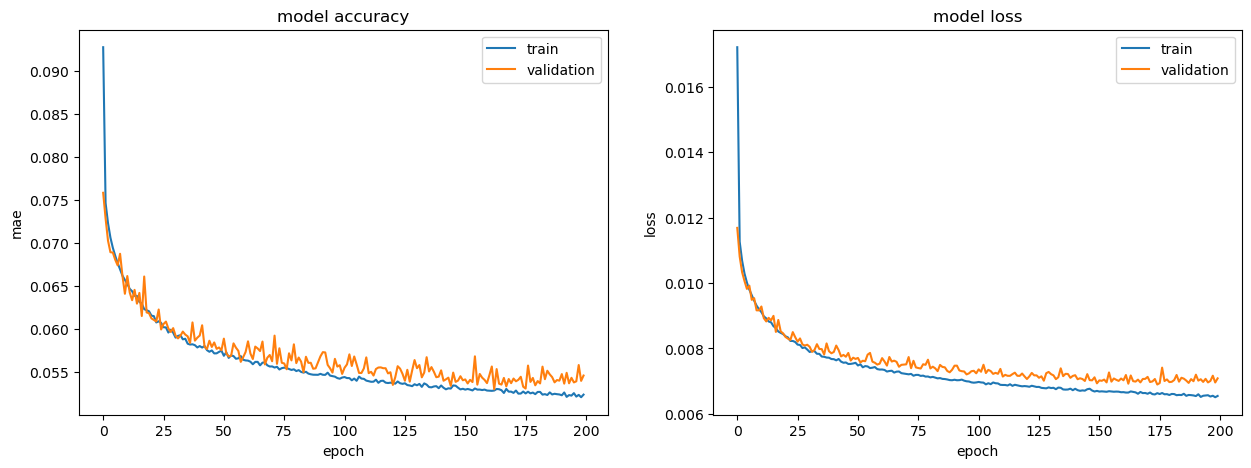

165/165 [==============================] - 0s 2ms/step - loss: 0.0070 - mae: 0.0542


,Model name,Total params,Activationfunction,Scaler,Optimizer,Epochs,Batch size,RMSE Train,RMSE Test,MAE Train,MAE Test
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,1024,1043.385871,1069.706070,3660.249977,3747.998430
0,Model 1,36865,relu,RobustScaler(),Adam,200,1024,24999.599064,25183.800139,26554.653887,26719.344828
0,Model 1,36865,relu,StandardScaler(),Adam,200,1024,26460.942436,26664.146162,27525.600980,27667.551281
0,Model 1,36865,relu,MinMaxScaler(),SGD,200,1024,1280.668686,1273.660406,4793.275096,4775.270096
0,Model 1,36865,relu,MinMaxScaler(),RMSprop,200,1024,1071.408925,1090.322143,3859.356738,3918.830739
0,Model 1,36865,elu,MinMaxScaler(),Adam,200,1024,1166.633256,1165.450877,4285.554900,4279.300869
0,Model 1,36865,tanh,MinMaxScaler(),Adam,200,1024,1128.226564,1127.745002,4079.782681,4074.268670
0,Model1,36865,relu,MinMaxScaler(),Adam,200,512,1042.498625,1068.421493,3645.769297,3731.838108
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,256,1027.677259,1062.102148,3589.121962,3706.280297
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,64,1042.670484,1078.163909,3676.699058,3796.029189


In [229]:
Model_name = "Model 5"
info = [Model_name, params, activation_func, scaler]

epochs = 200
batch_size = 1024

data = deeplearning(info, model, "Adam", epochs, batch_size, callback, scaler=scaler)
neural_results = neural_results.append(data)

neural_results

- Ajetaan edellisellä kerralla käytössä ollut malli, millä saatiin viimmeksi tulokseksi Test MAE 3653, mutta tällä kertaa jäätiin kauaksi siitä.

In [231]:
sample_size = X.shape[0]
factor = 10
io_neurons = X.shape[1] + 1

size = round(sample_size/(factor*io_neurons))
factor = 10
size2 = round(sample_size/(factor*io_neurons))



# Model 6
model = Sequential()

model.add(Dense(size, input_shape=input_shape, activation='relu'))
model.add(Dense(size2, activation='relu'))
model.add(Dense(size2, activation='relu'))
model.add(Dense(size2, activation='relu'))
model.add(Dense(1, activation="linear"))

model.summary()

params = model.count_params()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_112 (Dense)           (None, 3398)              50970     
                                                                 
 dense_113 (Dense)           (None, 3398)              11549802  
                                                                 
 dense_114 (Dense)           (None, 3398)              11549802  
                                                                 
 dense_115 (Dense)           (None, 3398)              11549802  
                                                                 
 dense_116 (Dense)           (None, 1)                 3399      
                                                                 
Total params: 34,703,775
Trainable params: 34,703,775
Non-trainable params: 0
_________________________________________________________________


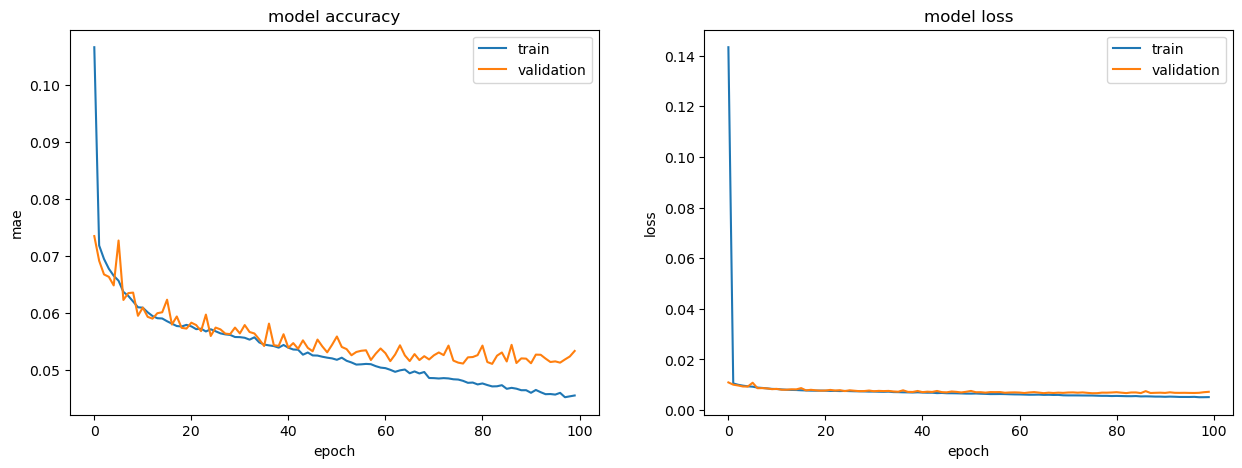

165/165 [==============================] - 2s 10ms/step - loss: 0.0072 - mae: 0.0533


,Model name,Total params,Activationfunction,Scaler,Optimizer,Epochs,Batch size,RMSE Train,RMSE Test,MAE Train,MAE Test
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,1024,1043.385871,1069.706070,3660.249977,3747.998430
0,Model 1,36865,relu,RobustScaler(),Adam,200,1024,24999.599064,25183.800139,26554.653887,26719.344828
0,Model 1,36865,relu,StandardScaler(),Adam,200,1024,26460.942436,26664.146162,27525.600980,27667.551281
0,Model 1,36865,relu,MinMaxScaler(),SGD,200,1024,1280.668686,1273.660406,4793.275096,4775.270096
0,Model 1,36865,relu,MinMaxScaler(),RMSprop,200,1024,1071.408925,1090.322143,3859.356738,3918.830739
0,Model 1,36865,elu,MinMaxScaler(),Adam,200,1024,1166.633256,1165.450877,4285.554900,4279.300869
0,Model 1,36865,tanh,MinMaxScaler(),Adam,200,1024,1128.226564,1127.745002,4079.782681,4074.268670
0,Model1,36865,relu,MinMaxScaler(),Adam,200,512,1042.498625,1068.421493,3645.769297,3731.838108
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,256,1027.677259,1062.102148,3589.121962,3706.280297
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,64,1042.670484,1078.163909,3676.699058,3796.029189


In [232]:
Model_name = "Model 6"
info = [Model_name, params, activation_func, scaler]

epochs = 100
batch_size = 1024

data = deeplearning(info, model, "Adam", epochs, batch_size, callback, scaler=scaler)
neural_results = neural_results.append(data)

neural_results

- Listätään 1 Dense kerros model 4:seen ja ajetaan se 100 epochilla. Tällä setillä tulos huononee aikaisempaan Model 4 verrattuna.

In [233]:
sample_size = X.shape[0]
factor = 8
io_neurons = X.shape[1] + 1

size = round(sample_size/(factor*io_neurons))
factor = 8
size2 = round(sample_size/(factor*io_neurons))



# Model 7
model = Sequential()

model.add(Dense(size, input_shape=input_shape, activation='relu'))
model.add(Dense(size2, activation='relu'))
model.add(Dense(1, activation="linear"))

model.summary()

params = model.count_params()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_117 (Dense)           (None, 4247)              63705     
                                                                 
 dense_118 (Dense)           (None, 4247)              18041256  
                                                                 
 dense_119 (Dense)           (None, 1)                 4248      
                                                                 
Total params: 18,109,209
Trainable params: 18,109,209
Non-trainable params: 0
_________________________________________________________________


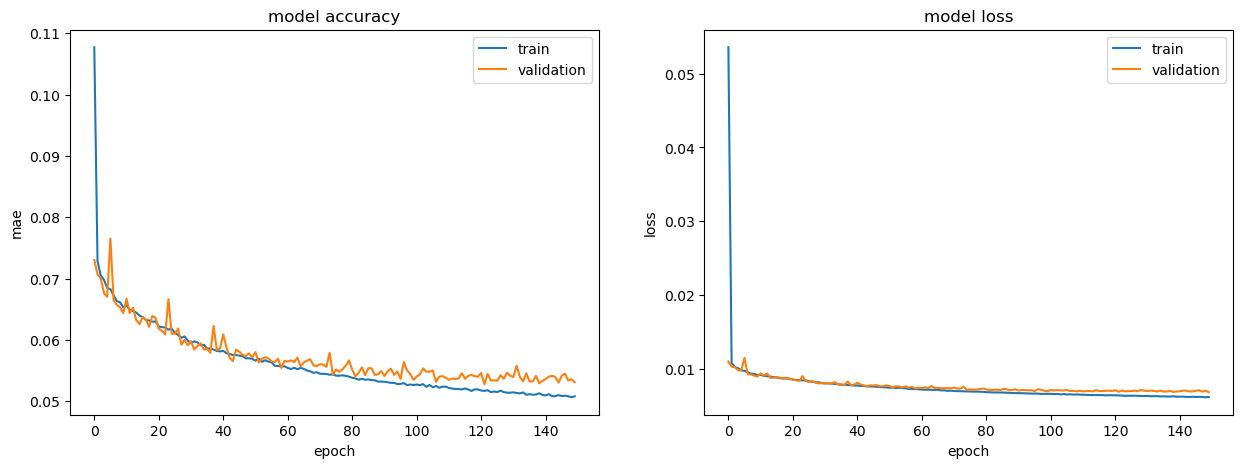

165/165 [==============================] - 1s 6ms/step - loss: 0.0068 - mae: 0.0530


,Model name,Total params,Activationfunction,Scaler,Optimizer,Epochs,Batch size,RMSE Train,RMSE Test,MAE Train,MAE Test
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,1024,1043.385871,1069.706070,3660.249977,3747.998430
0,Model 1,36865,relu,RobustScaler(),Adam,200,1024,24999.599064,25183.800139,26554.653887,26719.344828
0,Model 1,36865,relu,StandardScaler(),Adam,200,1024,26460.942436,26664.146162,27525.600980,27667.551281
0,Model 1,36865,relu,MinMaxScaler(),SGD,200,1024,1280.668686,1273.660406,4793.275096,4775.270096
0,Model 1,36865,relu,MinMaxScaler(),RMSprop,200,1024,1071.408925,1090.322143,3859.356738,3918.830739
0,Model 1,36865,elu,MinMaxScaler(),Adam,200,1024,1166.633256,1165.450877,4285.554900,4279.300869
0,Model 1,36865,tanh,MinMaxScaler(),Adam,200,1024,1128.226564,1127.745002,4079.782681,4074.268670
0,Model1,36865,relu,MinMaxScaler(),Adam,200,512,1042.498625,1068.421493,3645.769297,3731.838108
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,256,1027.677259,1062.102148,3589.121962,3706.280297
0,Model 1,36865,relu,MinMaxScaler(),Adam,200,64,1042.670484,1078.163909,3676.699058,3796.029189


In [234]:
Model_name = "Model 7"
info = [Model_name, params, activation_func, scaler]

epochs = 150
batch_size = 1024

data = deeplearning(info, model, "Adam", epochs, batch_size, callback, scaler=scaler)
neural_results = neural_results.append(data)

neural_results

- Viimmeisenä ajetaan vielä kahdella Dense kerroksella, jolloin tulos on keskimääräistä parempi, mutta jää silti parhaasta tuloksesta.



### Neurovekko analyysiä
- Neuroverkossa arvojen skaalaamisella oli erittäin suuri vaikutus lopputulokseen. Mikä on luonnollista, koska eri neuronien väliset weight-arvot muuttuvat vähemmän.
- Paras neuroverkko sisälsi 3 Dense kerrosta, joiden kaikkien koko oli 3398. Suuremmat neuroverkot yleensäkkin pärjäsivät hyvin. Tämä saattaa johtua siitä, että käytössä ollut data oli erittäin iso.
- Paras neuroverkko sai MAE arvon 3563, joka jäi päälle 1000 parhaasta koneoppimismallista.
- ROC kuvaajissa voidaan huomata, että Train Loss ja Accuracy pienenee melko jyrkästi, mutta validation loss ja accuracy poukkuoilee oudosti käyrän molemmilla puolilla, mikä ei ole optimaali tilanne. 

In [ ]:
# Otetaan mallin painoarvot talteen
#model.save("models/model-v1.h5")

#### Jatkokehitysideoita

- Koneoppimismallien hyperparametrit oli optimoitu käyttäen vain yhtä datasettiä. Mahdollisesti muiden datasettien tuloksia voisi parantaa, jos parametrit optimoitaisiin jokaiselle datasetille erikseen.

- Myös sarakkeiden karsiminen tehtiin vain yhden datasetin ehdoilla. Muilla dataseteillä karsimista voisi myös kokeilla ja tutkia vaikutuksia.

- Parhaimman koneoppimismallin hyperparametrien optimointi ja syvempi tutustuminen algoritmiin

- Feature importances -tuloksista saatujen tietojen avulla datan esikäsittelyä voisi tehostaa seuraavassa iteraatiossa. 

- Neuroverkkomalleissa voisi kokeilla käyttää testidataa validoinnissa, tai jättää validointi-setin kokonaan pois. Ehkä ROC-käyrät eivät olisi olleet välillä niin hämmentäviä.

- Mutta suurin parannus tarkkuuksiin saataisiin todennäköisesti, aloittamalla uusi kierros Crisp DM mallin mukaisesti ja palaamalla takaisin datan esikäsittelyyn.